<font color='black'>

# Final Project - Unsupervised Learning Models Part III 
## Group 2 - 90-803 Machine Learning Foundations with Python (Spring 2023)
### Authors: Samira Diabi, Amelia Janaskie, Genna Moellering


# 3. What common characteristics in terms of team performance emerge when teams are grouped together? For example, do all the most successful teams have a certain shooting percentage or number of steals per game?


**Models Used:**
* Principal Component Analysis (PCA)
* KMeans
* AgglomerativeClustering
* Gaussian Mixture Model
* DBSCAN

---

**The notebook is structured as follows:**

I. Reading in csv files and libraries

II. Feature Engineering

    - Fixing DataFrame
    - Scaling Data
    - Principal Component Analysis
    
III. Building the Models

    - KMeans
        - Model Selection
        - Model Results through Visualizations
    - Hierarchical Clustering
        - Model Selection
        - Model Results through Visualizations
    - Gaussian Mixture Model
        - Model Selection
        - Model Results through Visualizations
    - DBSCAN
        - Model Selection
        - Model Results through Visualizations

IV. Comparing Results Across Models

V. Conclusions

---

Importing relevant libraries that will be used in this notebook.

In [1]:
import numpy as np
import pandas as pd

# Modeling Libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV

# Visualization Libraries
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from yellowbrick.features import PCA as PCA_viz 

We set a seed below to be consistent across all models that use a `random_state`.

In [2]:
seed = 12

The code below identifies a few objects that will be used for visualizations later on.

In [3]:
# Creating a color for each cluster
palette_2_clusters = ['#0492c2', '#74b72e']
palette_3_clusters = ['#0492c2', '#74b72e', '#fa8128']
palette_4_clusters = ['#0492c2', '#74b72e', '#fa8128', '#af69ee']

# Creating a list of features that will be used for plotting
features = ['PPG', 'FG%', 'FG3%', 'FT%', 'OR_per_game', 'DR_per_game', 'Ast_per_game', 
            'TO_per_game', 'Stl_per_game', 'Blk_per_game', 'PF_per_game', 'Road_Wins', 
            'TotalD1Seasons', 'Qualified', 'Win']

# Subplot Titles
titles = ['Points Per Game', 'Field Goal %', 'Field Goal 3-Point %', 'Free Throw %', 
          'Offensive Rebounds Per Game','Defensive Rebounds Per Game', 'Assists Per Game', 
          'Turnovers Per Game', 'Steals Per Game', 'Blocks Per Game', 'Personal Fouls Per Game',
          'Number of Road Wins', 'Number of Seasons as D1', 'Qualified for Tournament', 
          'Total Wins']

The majority of our data will come from the `team_data` dataset, which is loaded in below. The first five rows are printed as a reminder on what is in this dataset. (It includes season-level stats for each team.)

In [4]:
# Reading in csv file
team_data = pd.read_csv('data/annual_team_data.csv')

# Printing first five rows
team_data.head()

Season  Team  PPG  FG%  FG3%  FT%  OR_per_game  DR_per_game  Ast_per_game  \
0    2003  1102   57   48    38   65            4           17            13   
1    2003  1103   79   49    34   74           10           20            15   
2    2003  1104   69   42    32   71           14           24            12   
3    2003  1105   72   40    36   71           14           23            15   
4    2003  1106   64   42    35   65           12           24            12   

   TO_per_game  Stl_per_game  Blk_per_game  PF_per_game  Road_Wins ConfAbbrev  \
0           11             6             2           19          3        mwc   
1           13             7             2           20          4        mac   
2           13             7             4           18          4        sec   
3           19             9             2           20          2       swac   
4           17             8             3           18          5       swac   

      TeamName  TotalD1Seasons Seed       CoachName  Qualified  
0    Air Force              39  NaN       joe_scott          0  
1        Akron              39  NaN     dan_hipsher          0  
2      Alabama              39  Y10  mark_gottfried          1  
3  Alabama A&M              24  NaN   vann_pettaway          0  
4   Alabama St              39  NaN     rob_spivery          0

The dataset below lacks one more important features, the number of wins for each team in a given season. Therefore, the `team_wins` dataset is used to include this feature.

In [5]:
# Reading in csv file
team_wins = pd.read_csv('data/team_wins.csv')

# Printing first five rows
team_wins.head()

Season  TeamID  Win
0    2003    1102   16
1    2003    1103   14
2    2003    1104   11
3    2003    1105   19
4    2003    1106   16

_______________________________________________________________________________________________________________________________

<h1><center>Feature Engineering</center></h1>

Before conducting the clustering, we'll go through a few feature engineering steps to prepare the data. First, we'll combine the two datasets (`team_data` and `team_wins`) below to get one, full dataframe.

In [6]:
# merging the data on Season and TeamID
df = team_data.merge(team_wins, left_on = ['Season', 'Team'], right_on = ['Season', 'TeamID'])

# Printing first 5 rows of dataframe
df.head()

Season  Team  PPG  FG%  FG3%  FT%  OR_per_game  DR_per_game  Ast_per_game  \
0    2003  1102   57   48    38   65            4           17            13   
1    2003  1103   79   49    34   74           10           20            15   
2    2003  1104   69   42    32   71           14           24            12   
3    2003  1105   72   40    36   71           14           23            15   
4    2003  1106   64   42    35   65           12           24            12   

   TO_per_game  ...  PF_per_game  Road_Wins  ConfAbbrev     TeamName  \
0           11  ...           19          3         mwc    Air Force   
1           13  ...           20          4         mac        Akron   
2           13  ...           18          4         sec      Alabama   
3           19  ...           20          2        swac  Alabama A&M   
4           17  ...           18          5        swac   Alabama St   

  TotalD1Seasons Seed       CoachName Qualified TeamID  Win  
0             39  NaN       joe_scott         0   1102   16  
1             39  NaN     dan_hipsher         0   1103   14  
2             39  Y10  mark_gottfried         1   1104   11  
3             24  NaN   vann_pettaway         0   1105   19  
4             39  NaN     rob_spivery         0   1106   16  

[5 rows x 22 columns]

There are a few features that were important for other questions of this project but will be dropped for the unsupervised learning portion of this project. This is because we want to cluster on game statistics/team performance (per the question) and not on external features, such as the team's conference. Therefore, we drop a few features from the dataframe in the code below.

In [7]:
# Dropping columns that will not be used for clustering
df.drop(columns = ['Seed', 'CoachName', 'ConfAbbrev', 'Season', 'Team', 'TeamName', 'TeamID'], inplace = True)

An important component of feature engineering is making sure the data is scaled properly. First, we'll look at the data to see if it requires scaling.

In [8]:
# Looking at the ranges of feature values to see if it needs scaling
df.describe()

PPG          FG%         FG3%         FT%  OR_per_game  \
count  7255.000000  7255.000000  7255.000000  7255.00000  7255.000000   
mean     69.519504    43.617367    34.274156    69.80000    10.551068   
std       5.792704     2.646059     2.866136     3.94113     2.036232   
min      49.000000    34.000000    25.000000    54.00000     4.000000   
25%      66.000000    42.000000    32.000000    67.00000     9.000000   
50%      69.000000    44.000000    34.000000    70.00000    11.000000   
75%      73.000000    45.000000    36.000000    72.00000    12.000000   
max      96.000000    55.000000    45.000000    83.00000    17.000000   

       DR_per_game  Ast_per_game  TO_per_game  Stl_per_game  Blk_per_game  \
count  7255.000000   7255.000000  7255.000000   7255.000000    7255.00000   
mean     23.648105     13.020538    13.460648      6.479256       3.30448   
std       2.011499      1.872410     1.876476      1.282350       1.11735   
min      15.000000      8.000000     7.000000      3.000000       1.00000   
25%      22.000000     12.000000    12.000000      6.000000       3.00000   
50%      24.000000     13.000000    13.000000      6.000000       3.00000   
75%      25.000000     14.000000    15.000000      7.000000       4.00000   
max      31.000000     21.000000    22.000000     13.000000       9.00000   

       PF_per_game    Road_Wins  TotalD1Seasons    Qualified          Win  
count  7255.000000  7255.000000     7255.000000  7255.000000  7255.000000  
mean     17.776017     6.101447       36.112061     0.184149    15.266437  
std       3.419705     3.353153        6.868992     0.387632     4.220618  
min       0.000000     0.000000        1.000000     0.000000     1.000000  
25%      17.000000     4.000000       39.000000     0.000000    12.000000  
50%      18.000000     6.000000       39.000000     0.000000    15.000000  
75%      20.000000     8.000000       39.000000     0.000000    18.000000  
max      28.000000    18.000000       39.000000     1.000000    32.000000

Yes, the df needs scaling but it is unclear what kind of scaling would be best. Therefore, we look at the histogram plot below to get a better idea of the distributions.

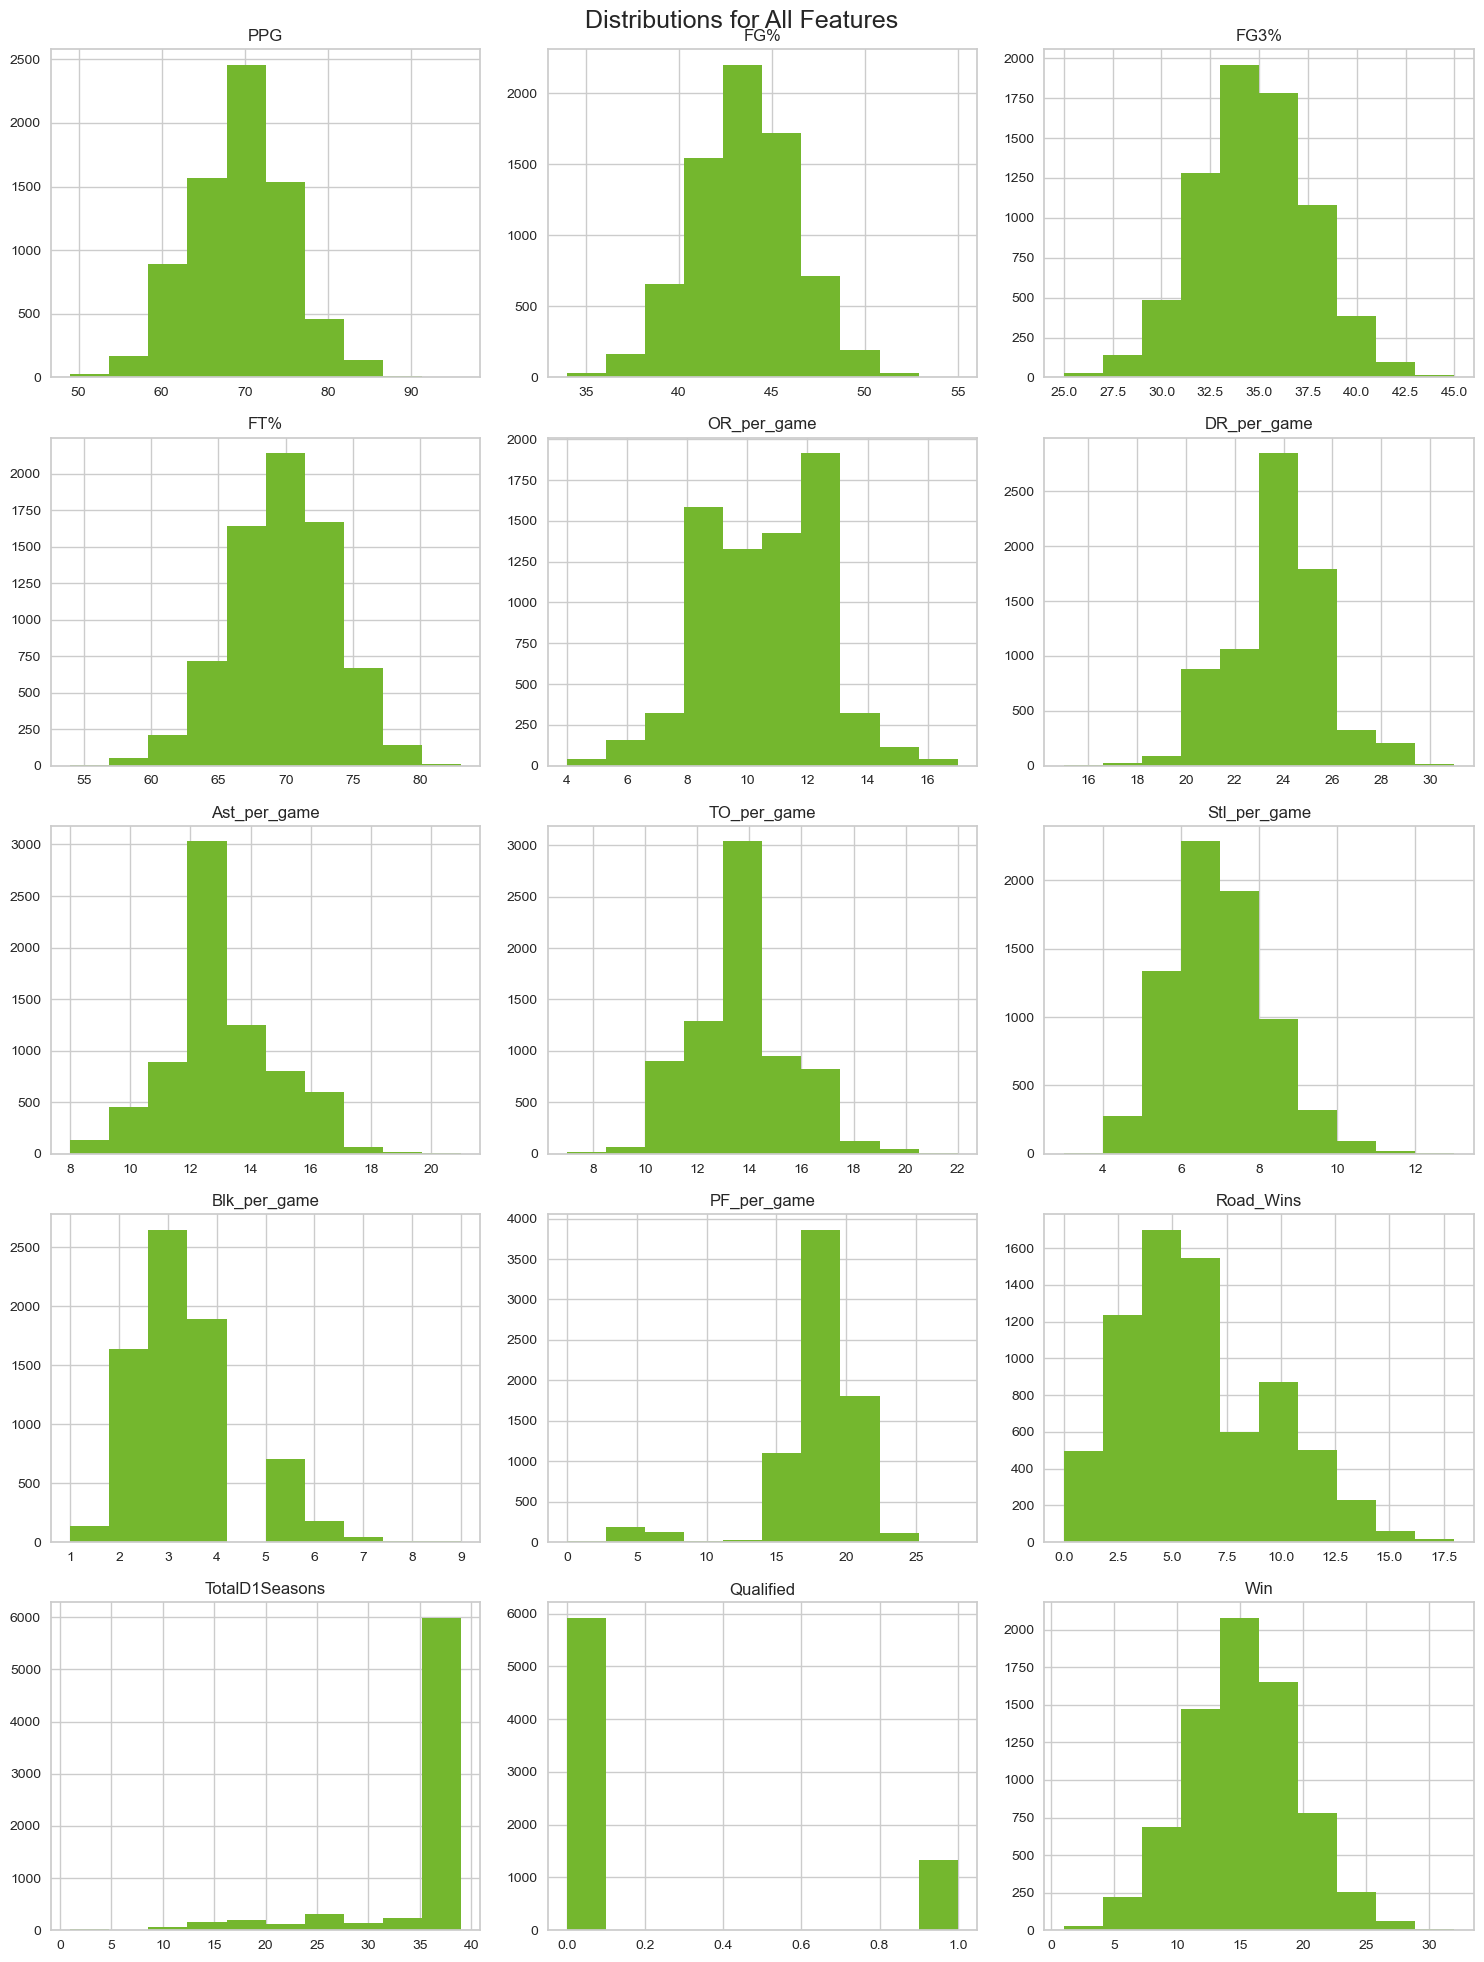

In [9]:
# Initializing subplots
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

# Setting axis indexes
j=0
h=0

# Creating for loop to plot each feature
for i in features:
    
    ax[h,j].hist(x = df[i], color = '#74b72e') # Plotting each feature
    ax[h, j].set_title(i) # Plotting the title
    ax[h, j].set_facecolor('white')
    
    # Specifying index for each plot
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1

        
# Main title
plt.suptitle('Distributions for All Features', fontsize = 18)
plt.tight_layout()

Because the features all have different ranges of values, some might have more weight than others. So, to protect from skewing simply by numbers being larger than others, we transform the features so they are all treated equally. The only feature that is removed from scaling is `Qualified` because it is a binary variable.

In [10]:
# Getting non-binary variables only to standardize
X = df[df.columns.difference(['Qualified'])]
bin_var = df['Qualified']

# Creating an object to use to standardizing the data
pt = PowerTransformer()

# Standardizing the games data
games_std = pt.fit_transform(X)

# Creating a new df with the standardized features, all will be X since this focuses on clustering
X = pd.DataFrame(games_std, columns = X.columns)

# Merging back binary variable
X = pd.concat([X, bin_var], axis = 1)

# Creating copy of X df to be used later
X_copy = X.copy()

# Printing attributes of X
print('Rows: ', X.shape[0])
print('Columns: ', X.shape[1])

# Printing first 5 rows of outcome
X.head()

Rows:  7255
Columns:  15


Ast_per_game  Blk_per_game  DR_per_game       FG%      FG3%       FT%  \
0      0.037876     -1.251867    -3.411210  1.660529  1.297951 -1.209660   
1      1.056053     -1.251867    -1.836602  2.041626 -0.092757  1.072969   
2     -0.511689      0.695282     0.184077 -0.612826 -0.792304  0.281999   
3      1.056053     -1.251867    -0.313566 -1.365254  0.603939  0.281999   
4     -0.511689     -0.176502     0.184077 -0.612826  0.255937 -1.209660   

   OR_per_game  PF_per_game       PPG  Road_Wins  Stl_per_game  TO_per_game  \
0    -3.027137     0.299997 -2.189919  -0.905769     -0.309035    -1.358660   
1    -0.288553     0.773974  1.624737  -0.549829      0.473917    -0.199599   
2     1.730477    -0.127217 -0.082377  -0.549829      0.473917    -0.199599   
3     1.730477     0.773974  0.434062  -1.303446      1.801802     2.651748   
4     0.705334    -0.127217 -0.952006  -0.223964      1.171760     1.784032   

   TotalD1Seasons       Win  Qualified  
0        0.488066  0.179649          0  
1        0.488066 -0.293854          0  
2        0.488066 -1.009832          1  
3       -2.260126  0.885106          0  
4        0.488066  0.179649          0

### PCA

Now that we have scaled our data, we will perform dimensionality reduction to get the most important components for our model. We will use Principal Component Analyis or `PCA()` from Sklearn.

Below, we create a table showing the explained variance for each principal component and the cumulative explained variance.

In [11]:
# Initializing PCA model
pca = PCA(random_state = seed)

# Fitting the data to the PCA model
pca.fit_transform(X)

# Getting the explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Creating a df to contrain all data on explained variance for each PC
feature_ev = pd.DataFrame({'Principal Component' : ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                                                     'PC11', 'PC12', 'PC13', 'PC14', 'PC15'], 
                           'Explained Variance' : explained_variance, 
                           'Cumulative Exp Variance' : np.cumsum(pca.explained_variance_ratio_)})

# Printing the actual data for explained variance for each PC
feature_ev

Principal Component  Explained Variance  Cumulative Exp Variance
0                  PC1            0.268613                 0.268613
1                  PC2            0.152375                 0.420988
2                  PC3            0.091744                 0.512733
3                  PC4            0.076956                 0.589689
4                  PC5            0.073960                 0.663649
5                  PC6            0.064978                 0.728627
6                  PC7            0.054443                 0.783070
7                  PC8            0.045904                 0.828974
8                  PC9            0.042163                 0.871137
9                 PC10            0.035352                 0.906489
10                PC11            0.032074                 0.938564
11                PC12            0.024367                 0.962931
12                PC13            0.020387                 0.983317
13                PC14            0.009836                 0.993153
14                PC15            0.006847                 1.000000

The dataframe above shows that once we reach Principal Component 10, we start getting an explained variance above 90%. We'll likely cut off our PC somewhere between Principal Component 10 and 15, which we'll decide by looking at the graph below.

To get a better sense of what features are included in each principal component, we create a dataframe below to look at the relationships.

In [12]:
# Creating a df to compare features and PCs
pca_loading_vectors = pd.DataFrame(PCA().fit(X).components_, 
                                    index=X.columns, 
                                    columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                                                     'PC11', 'PC12', 'PC13', 'PC14', 'PC15'])
# Printing df
pca_loading_vectors

PC1       PC2       PC3       PC4       PC5       PC6  \
Ast_per_game   -0.377139 -0.147744 -0.268111 -0.432743 -0.346802 -0.242912   
Blk_per_game    0.156353  0.314970  0.137412 -0.010479 -0.112839 -0.301083   
DR_per_game    -0.177439  0.458809  0.450148 -0.167251 -0.311619 -0.117834   
FG%             0.082779  0.080662  0.383772  0.045720  0.028630 -0.055302   
FG3%            0.101935  0.163355 -0.281517  0.033203 -0.137863 -0.143575   
FT%            -0.113754  0.158100  0.032392 -0.093906 -0.266815 -0.060733   
OR_per_game    -0.269534  0.012385  0.038050 -0.281132 -0.199706  0.674851   
PF_per_game     0.116188  0.524012 -0.072913  0.049564 -0.070325  0.411620   
PPG             0.336074 -0.548187  0.292162 -0.106845 -0.438010  0.102823   
Road_Wins      -0.339934 -0.150872  0.258759  0.144745 -0.100522  0.118629   
Stl_per_game   -0.035815  0.008849 -0.243072 -0.085754  0.247972  0.321374   
TO_per_game     0.497571  0.066602 -0.290582  0.187410 -0.515911  0.145274   
TotalD1Seasons -0.453792 -0.021862 -0.250951  0.632675 -0.321700 -0.069449   
Win             0.039761  0.083451 -0.331130 -0.448305 -0.018813 -0.168623   
Qualified      -0.025203 -0.017391 -0.061601 -0.122680 -0.024270 -0.044213   

                     PC7       PC8       PC9      PC10      PC11      PC12  \
Ast_per_game    0.041017  0.138531 -0.424632 -0.363904 -0.025770  0.217879   
Blk_per_game    0.553216  0.360001  0.177682  0.088333  0.373728  0.364009   
DR_per_game     0.066578 -0.285364 -0.088204  0.046561 -0.334688 -0.216890   
FG%            -0.002990 -0.053744  0.076814 -0.226001 -0.385073  0.299139   
FG3%           -0.065403 -0.469101 -0.071873 -0.007588  0.428455 -0.105466   
FT%             0.018304 -0.229507  0.032370  0.287587  0.257422 -0.243864   
OR_per_game     0.183340  0.301197  0.212119  0.075822  0.090729 -0.211406   
PF_per_game    -0.345552 -0.054387  0.023739 -0.436524  0.199292  0.320308   
PPG             0.076262 -0.304204  0.254555 -0.231380  0.156920  0.102299   
Road_Wins      -0.309059 -0.068624 -0.190574  0.512645  0.175446  0.550782   
Stl_per_game    0.581520 -0.504084 -0.142204  0.085832 -0.194825  0.301883   
TO_per_game    -0.001764  0.197928 -0.293288  0.300088 -0.345029  0.037347   
TotalD1Seasons  0.137691 -0.055419  0.383904 -0.160401 -0.156383  0.025303   
Win            -0.246428 -0.078647  0.591992  0.281264 -0.245784  0.231228   
Qualified      -0.104923  0.026417  0.132178 -0.094136 -0.065613  0.071818   

                    PC13      PC14      PC15  
Ast_per_game   -0.071023 -0.025799 -0.100263  
Blk_per_game    0.069840  0.026552  0.034538  
DR_per_game     0.343994  0.205920  0.028404  
FG%            -0.320591 -0.655744 -0.054526  
FG3%            0.330834 -0.554918  0.036216  
FT%            -0.781547  0.050934  0.037540  
OR_per_game     0.119593 -0.330307 -0.001834  
PF_per_game    -0.100927  0.244935 -0.061544  
PPG             0.052632  0.176895 -0.038776  
Road_Wins       0.117793 -0.019253  0.043132  
Stl_per_game   -0.063737  0.102565  0.062463  
TO_per_game    -0.014827 -0.052055  0.050393  
TotalD1Seasons  0.008532  0.034376 -0.023141  
Win             0.055099  0.022728 -0.195290  
Qualified      -0.013245 -0.003436  0.964357

As shown in the dataframe above, the features that contribute the most to `PC1` are `PPG`, `TO_per_game`, `Blk_per_game`, `PF_per_game`, and a few more.Interestingly, number of wins does not contribute a great deal to `PC1`. We'll pay close attention to `PPG` across each model to see how it is clustered. Another feature we're interested in, given the results of other models, is clustering with respect to `Road_Wins` so we'll watch that feature as well.

However, first we need to choose the best number of components to contribute to the model. Let's look at the graph below to select a best number.

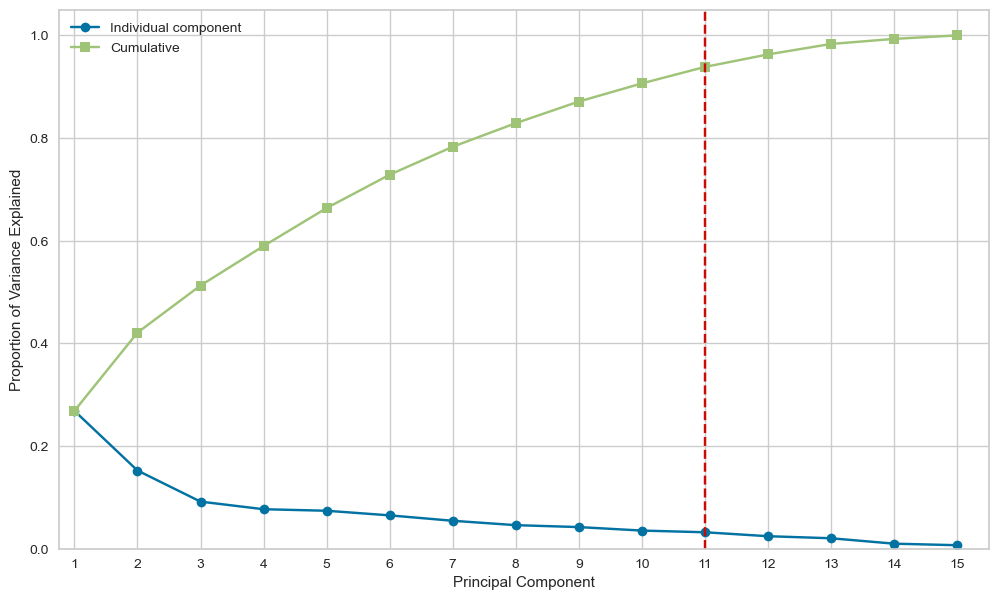

In [13]:
# Sizing the figure
plt.figure(figsize = (12,7))

# Plotting the explained variance ratio
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], pca.explained_variance_ratio_, '-o', label='Individual component')

# Plotting the cumulative explained variance ratio
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

# Setting the axes labels, limits, and tick marks
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,15.5)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

# Plotting line to indicate cutoff for PC
plt.axvline(color='r', x = 11, linestyle = '--')

# Setting location of legend
plt.legend(loc=2)

# Setting Style
sns.set_style('whitegrid')
plt.show();

At `PC11`, we're explaining 93.8% of the data, which is a reasonable number. We'll select the first 11 principal components and use them for each of our models.

In [14]:
# Setting number of components for PCA
n_components = 11

# Initializing final PCA model
pca = PCA(random_state = seed, n_components = n_components)

# Putting PCA components into a dataframe
df_pca = pd.DataFrame(pca.fit_transform(X), columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 
                                                     'PC10', 'PC11'], index = X.index)
# Creating a copy for X
X = df_pca.copy()

# Printing first five rows of X
X.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.078405 -3.270116 -2.194690 -1.749236  1.097065 -1.324573 -2.437166   
1 -1.291644 -0.332034 -2.449644 -0.674650  0.431873 -1.130778  0.522751   
2  0.654676  1.163439  0.809799  0.356705  0.990077  0.094410  1.369759   
3  1.339293  2.284866 -2.879236  0.340161 -1.428448  0.736689 -0.274370   
4  1.474712  1.506732 -0.164697 -0.139300  0.437904 -0.466764 -0.951828   

        PC8       PC9      PC10      PC11  
0 -0.027351 -1.960824 -0.628775 -1.444588  
1  0.406801  0.755548 -0.740246 -0.517249  
2 -0.236406  0.088466 -0.565858  0.725095  
3  1.099428  1.767266 -0.329541  1.500155  
4 -0.062262  0.140524  1.081907  0.575832

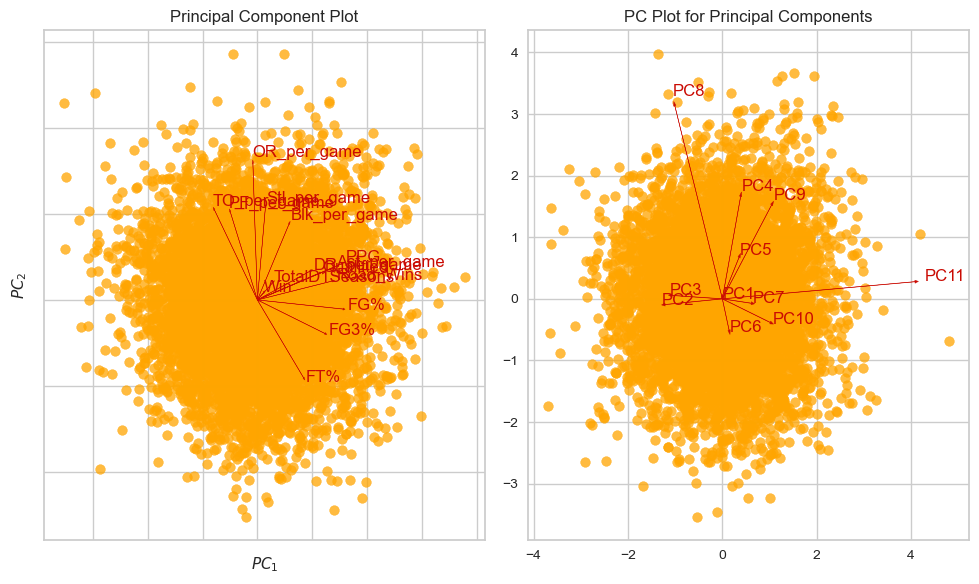

<Figure size 800x550 with 0 Axes>

In [15]:
# Initializing subplots
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

# Instantiating PCA viz models
visualizer_feat = PCA_viz(scale=True, proj_features=True, colors = ['orange'], ax = ax[0])
visualizer_pca = PCA_viz(scale=True, proj_features=True, colors = ['orange'], ax = ax[1])

# Fitting feature and PC data to each model
visualizer_feat.fit_transform(X_copy)
visualizer_pca.fit_transform(X)


# Setting the title for each plot
ax[0].set_title('PC Plot for Features')
ax[1].set_title('PC Plot for Principal Components')

# Setting style
sns.set_style('whitegrid')

# Plotting models
visualizer_feat.show()
visualizer_pca.show();

---

<h1><center>Building the Models</center></h1>


## K-Means Clustering

One important aspect of K-Means clustering is choosing the number of clusters. To determine the best number of clusters for KMeans, we'll look at 3 different metrics 1) distortion score, 2) calinski-harabasz, and 3) silhouette score.

The first plots below look at the distortion score and calinski-harabasz.

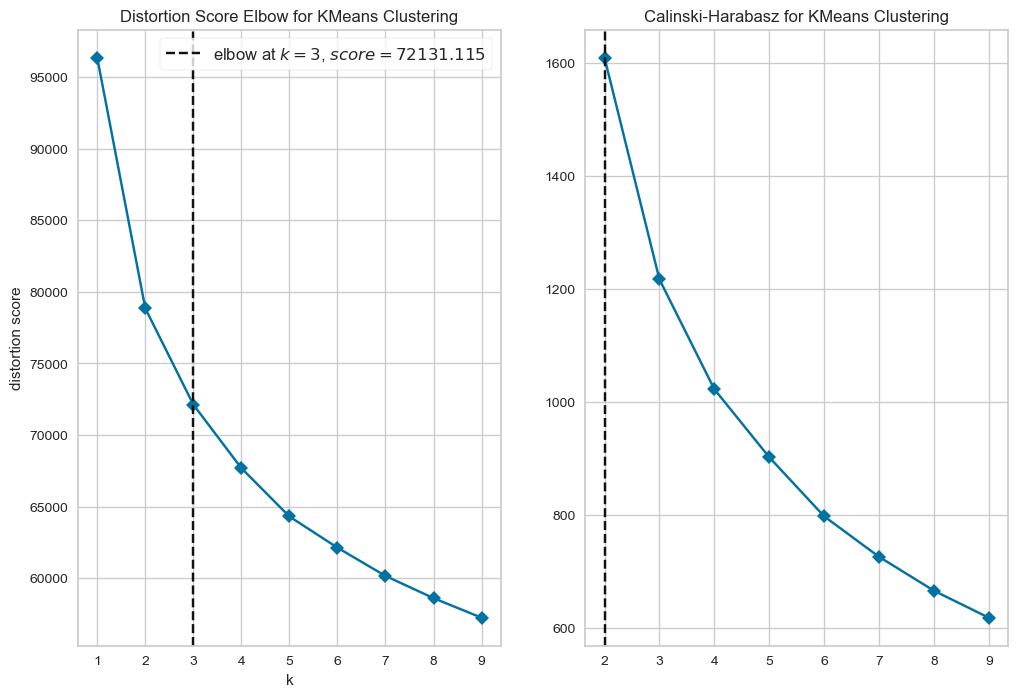

In [16]:
# Instantiating preliminary KMeans model
kmeans_pca = KMeans(random_state = seed, n_init = 'auto')

# Initializing subplots
fig, ax = plt.subplots(1, 2, figsize = (12, 8))

# Creating elbow plots to look at both metrics
visualizer = KElbowVisualizer(kmeans_pca, k=(1, 10), locate_elbow=True, timings=False, ax = ax[0])
visualizer2 = KElbowVisualizer(kmeans_pca, k=(2, 10), metric='calinski_harabasz', locate_elbow=True, 
                               timings=False, ax = ax[1])

# Fitting data to elbow visualizers
visualizer.fit(X)
visualizer2.fit(X)

# Adding title for second plot
ax[1].set_title('Calinski-Harabasz for KMeans Clustering')

# Setting style
sns.set_style('whitegrid')

# Plotting elbow plots
visualizer.show()
visualizer2.show();

The distortion score and the calinski-harabasz tell us two different clusters. Distortion finds 3 clusters to be the best whereas calinski-harabasz suggests 2. We'll look at the silhouette scores below to break the tie.

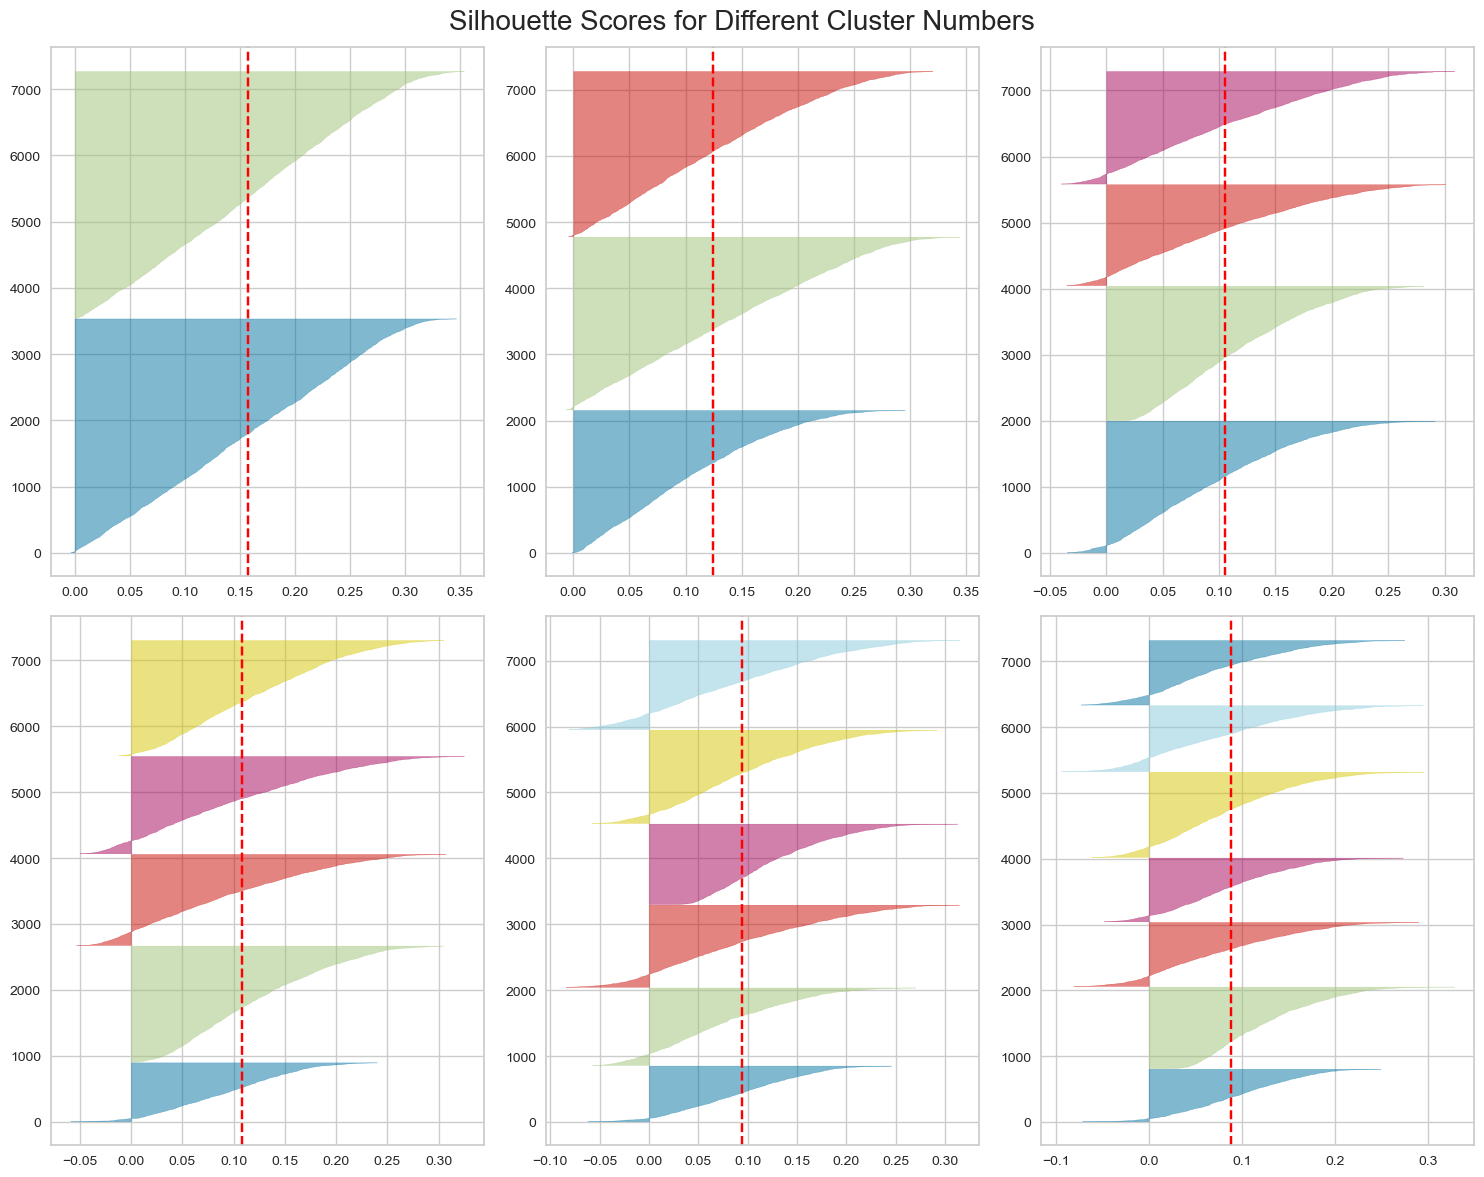

In [17]:
# Inititalizing subplots
fig, ax = plt.subplots(2, 3, figsize=(15,12))

# Setting index variables for plotting
j=0
h=0

# setting for loop with range of 2-7 clusers
for i in range(2,8):
    
    # Instantiating KMeans model that will have different cluster numbers iterate through
    model = KMeans(random_state = seed, n_clusters = i, n_init = 'auto')
    
    # Initializing Silhouette visualizer to look at clusters
    viz = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[h][j])
    
    # Setting indexes for each plot
    if j <2:
        j = j+1
    else:
        j=0
        h = h+1
    viz.fit(X)
    
    
# Setting Title and Style of plots
fig.suptitle('Silhouette Scores for Different Cluster Numbers', fontsize = 20)
sns.set_style('whitegrid')
plt.tight_layout()

Looking at above, both 2 and 3 clusters appear to be performing well as suggested by the elbow plots above. Let's look at the actual silhouette scores to see if 2 or 3 is better.

In [18]:
# Setting a range of possible clusters
n_clusters = range(2, 9)

# Looping through cluster number to find optimal silhouette score
for i in n_clusters:
    
    # Running KMeans Model with different cluster number
    clusters = KMeans(n_clusters=i, random_state = seed, n_init = 'auto')
    
    # Fitting data to model
    clusters.fit(X)
    
    # Printing silhouette score corresponding to each k
    print("k = ",i,"- silhouette score = %.3f" % silhouette_score(X, clusters.labels_),"\n")

k =  2 - silhouette score = 0.158 

k =  3 - silhouette score = 0.124 

k =  4 - silhouette score = 0.105 

k =  5 - silhouette score = 0.108 

k =  6 - silhouette score = 0.094 

k =  7 - silhouette score = 0.088 

k =  8 - silhouette score = 0.084 



As shown by the silhouette plots and the actual calculations of the silhouette score, 2 and 3 clusters appear to be the best. The plots are hard to tell if 2 or 3 is better, but the silhouette score is higher for 2 clusters so we choose 2 clusters as the best for KMeans.

**Best KMeans Model: Two Clusters**

In [19]:
# Instantiating Best KMeans
kmeans_pca = KMeans(n_clusters = 2, random_state = seed, n_init = 'auto')

# Fitting data to model
kmeans_pca.fit(X)

KMeans(n_clusters=2, n_init='auto', random_state=12)

Below, we create a dataframe called `results_kmeans` with the results of the cluster so that every row from the data `X` is assigned its correct cluster according to KMeans. The dataframe will be used for visualizing results.

In [20]:
# Combining original df with feature names and transformed df with principal components
results_kmeans = pd.concat([X_copy.reset_index(drop = True), pd.DataFrame(X)], axis = 1)

# Creating a new column for each row to indicate its cluster
results_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

# Creating a new column to rename clusters as First and Second in place of 0 and 1
results_kmeans['Cluster'] = results_kmeans['Segment K-means PCA'].map({0 : 'First', 1: 'Second'})

# Printing first five rows of results of KMeans
results_kmeans.head()

Ast_per_game  Blk_per_game  DR_per_game       FG%      FG3%       FT%  \
0      0.037876     -1.251867    -3.411210  1.660529  1.297951 -1.209660   
1      1.056053     -1.251867    -1.836602  2.041626 -0.092757  1.072969   
2     -0.511689      0.695282     0.184077 -0.612826 -0.792304  0.281999   
3      1.056053     -1.251867    -0.313566 -1.365254  0.603939  0.281999   
4     -0.511689     -0.176502     0.184077 -0.612826  0.255937 -1.209660   

   OR_per_game  PF_per_game       PPG  Road_Wins  ...       PC4       PC5  \
0    -3.027137     0.299997 -2.189919  -0.905769  ... -1.749236  1.097065   
1    -0.288553     0.773974  1.624737  -0.549829  ... -0.674650  0.431873   
2     1.730477    -0.127217 -0.082377  -0.549829  ...  0.356705  0.990077   
3     1.730477     0.773974  0.434062  -1.303446  ...  0.340161 -1.428448   
4     0.705334    -0.127217 -0.952006  -0.223964  ... -0.139300  0.437904   

        PC6       PC7       PC8       PC9      PC10      PC11  \
0 -1.324573 -2.437166 -0.027351 -1.960824 -0.628775 -1.444588   
1 -1.130778  0.522751  0.406801  0.755548 -0.740246 -0.517249   
2  0.094410  1.369759 -0.236406  0.088466 -0.565858  0.725095   
3  0.736689 -0.274370  1.099428  1.767266 -0.329541  1.500155   
4 -0.466764 -0.951828 -0.062262  0.140524  1.081907  0.575832   

   Segment K-means PCA  Cluster  
0                    0    First  
1                    1   Second  
2                    0    First  
3                    0    First  
4                    0    First  

[5 rows x 28 columns]

Now, let's look at the results of the KMeans and how it clustered the data with respect to the principal components. (Later in the notebook we'll look at actual features.)

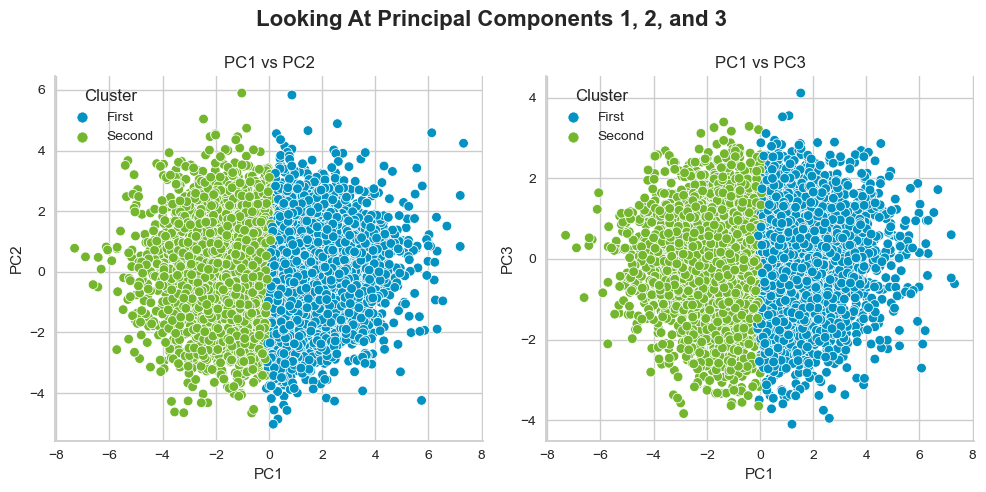

In [21]:
# Initializing subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creating for loop to plot each PC
sns.scatterplot(data = results_kmeans, x = "PC1", y = 'PC2', ax = ax[0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'])
sns.scatterplot(data = results_kmeans, x = "PC1", y = 'PC3', ax = ax[1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'])

# Setting title
ax[0].set_title('PC1 vs PC2')
ax[1].set_title('PC1 vs PC3')


# Main title and other style edits
plt.suptitle('Looking At Principal Components 1, 2, and 3', fontsize = 16, fontweight='bold')
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

There appears to be a clear cut down the middle of the data to divide into cluster 1 and 2. Although the line isn't necessarily straight down the middle, there doesn't appear to be a lot of confusion or incorrect clustering.

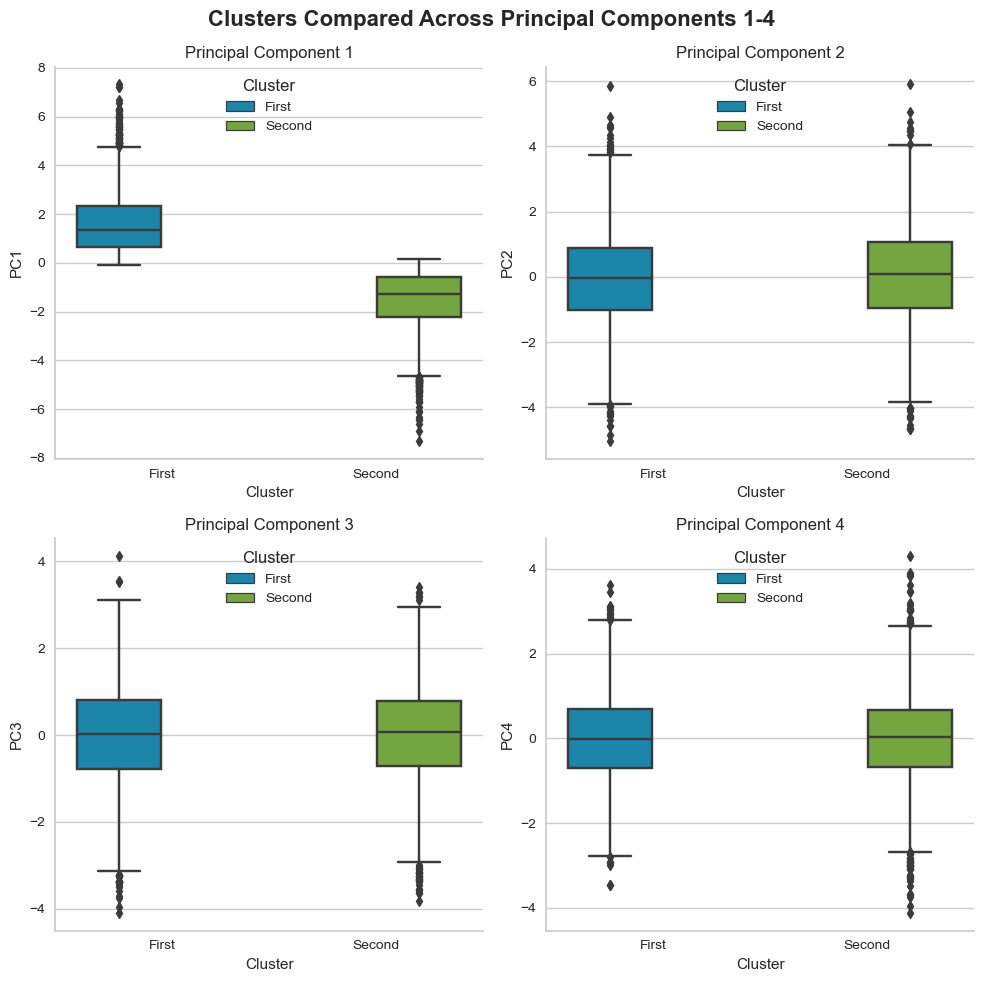

In [22]:
# Initializing subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Creating for loop to plot each PC
sns.boxplot(data = results_kmeans, x = "Cluster", y = 'PC1', ax = ax[0, 0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'])
sns.boxplot(data = results_kmeans, x = "Cluster", y = 'PC2', ax = ax[0, 1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'])
sns.boxplot(data = results_kmeans, x = "Cluster", y = 'PC3', ax = ax[1, 0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'])
sns.boxplot(data = results_kmeans, x = "Cluster", y = 'PC4', ax = ax[1, 1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'])

# Setting title
ax[0, 0].set_title('Principal Component 1')
ax[0, 1].set_title('Principal Component 2')
ax[1, 0].set_title('Principal Component 3')
ax[1, 1].set_title('Principal Component 4')

# Setting legend location
ax[0, 0].legend(loc='upper center', title = 'Cluster')
ax[0, 1].legend(loc='upper center', title = 'Cluster')
ax[1, 0].legend(loc='upper center', title = 'Cluster')
ax[1, 1].legend(loc='upper center', title = 'Cluster')

# Main title and other style edits
plt.suptitle('Clusters Compared Across Principal Components 1-4', fontsize = 16, fontweight='bold')
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

The Principal Component Boxplots to for Principal Components 1-4 shows us that the differentiation between the two clusters is most apparent for Principal Component 1. We see that the interquartile range for Cluster 1 is higher than Cluster 2's IQR. The clusters level off for PC2, PC3, and PC4 as shown by the other 3 boxplots.

Now, we'll look at a 3D plot of PC 1, 2, and 3.

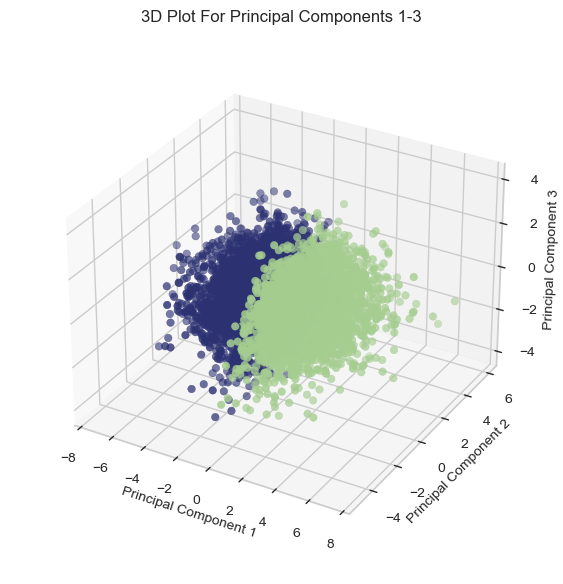

In [23]:
# Setting 3D Figure
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Specifying x and y axes
x = np.array(results_kmeans['PC1'])
y = np.array(results_kmeans['PC2'])
z = np.array(results_kmeans['PC3'])

# Setting axes labels
ax.set_xlabel('Principal Component 1', fontsize=10, rotation=150)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10, rotation=90)

# Plotting scatterplot
ax.scatter(x,y,z, c = results_kmeans["Segment K-means PCA"], s=30, cmap = "crest")

# Setting title
plt.title('3D Plot For Principal Components 1-3')

# Scaling plot
ax.set_box_aspect(None, zoom=0.9)
plt.tight_layout()

The 3-D plot displays similar information that we saw in the 2D plot. There is a clear cut down the middle of the data to differentiate cluster 1 and 2.

## Hierarchical Clustering

There are 4 different Hierarchical Clustering methods used in this section combined with different metric techniques. A function is created below to easily compute each method. The methods and metrics follow this order:

1. Ward
    - Euclidean
2. Average
    - Euclidean
    - Correlation
    - Cosine
    - Minkowski
3. Complete
    - Euclidean
    - Correlation
    - Cosine
    - Minkowski
4. Single*
    - Euclidean
    - Correlation
    - Cosine
    - Minkowski
    
\* Single causes the kernel to die due to challenges with chaining and creating a complicated dendogram, given the shape of the data. Therefore, the single dendrograms are commented out.

First, we'll look at the silhouette scores to get an idea of which linkages and metrics are performing best. We specify 2 clusters because after looking a dendrograms 2 is the best number of clusters.

In [24]:
# Instantiating ward HC model
ward = AgglomerativeClustering(linkage = 'ward', compute_distances = True, n_clusters = 2)

# Fitting data to HC model
ward.fit(X)

# Printing Silhouette Score
print('Silhouette Score for Ward Linkage: %.5f' % silhouette_score(X, ward.labels_))

Silhouette Score for Ward Linkage: 0.11177


Now, we'll loop through all other potential linkages and metrics for HC.

In [25]:
# Creating lists of potential methods and metrics for HC
method = ['average', 'complete', 'single']
metric = ['euclidean', 'cosine', 'correlation', 'minkowski']

# Creating empty lists to capture all data
met = []  # List for methods
metr = [] # List for metrics
sil = []  # List for silhouette score

# Looping through method and metrics to find optimal silhouette score
for i in method:
    for q in metric:
        # Running KMeans Model with different cluster number
        clustershc = AgglomerativeClustering(linkage = i, metric = q, n_clusters = 2)

        # Fitting data to model
        clustershc.fit(X)
        
        # Printing silhouette score corresponding to each k
        s = silhouette_score(X, clustershc.labels_)
        
        # Appending information to lists
        sil.append(s)
        met.append(i)
        metr.append(q)

Now we'll create a dataframe to look at the results.

In [26]:
# Creating a df to organize linkage, metric, and corresponding silhouette scores
hc_metrics = pd.DataFrame({'Method' : met, 'Metric' : metr, 'Silhouette_Score' : sil})

# Adding a row for silhouette score for Ward linkage
hc_metrics.loc[len(hc_metrics.index)] = ['ward', 'euclidean', 0.11177]

# Sorting by best silhouette scores
hc_metrics.sort_values(by="Silhouette_Score", ascending = False).head(5)

Method     Metric  Silhouette_Score
0   average  euclidean          0.398466
3   average  minkowski          0.398466
8    single  euclidean          0.335639
11   single  minkowski          0.335639
12     ward  euclidean          0.111770

The sorted dataframe show that these combinations of metrics and methods provide the best silhouette scores. While the silhouette score can be useful, we must look at dendrograms to look at distance as it is an important consideration for Hierarchical Clustering.

Therefore, below we create a function to create dendrograms for all combinations of methods and metrics. We'll look at the dendrograms to see which hierarchy looks the best.

In [27]:
# Creating a function to plot dendrograms
def hiercluster(method, metric):
    
    # Creating linkage using method and metric previously specified
    hc_cluster = shc.linkage(X, method = method, metric = metric)
    
    # Determining Figure Size
    plt.figure(figsize=(20,10))
    
    # Setting title with specifications of linkage type
    plt.title("Hierarchical Clustering, Method: " + method.title() + ", Metric: " + metric.title(), fontsize = 18)
    
    # Setting plot labels
    plt.xlabel("Index")
    plt.ylabel("Distance")
    
    # Setting grid style to None
    plt.grid(visible=None)
    
    # Plotting dendrogram
    d = shc.dendrogram(hc_cluster, leaf_font_size=15, truncate_mode="lastp",
          p=20,show_contracted=True)

Ward linkage and euclidean metric:

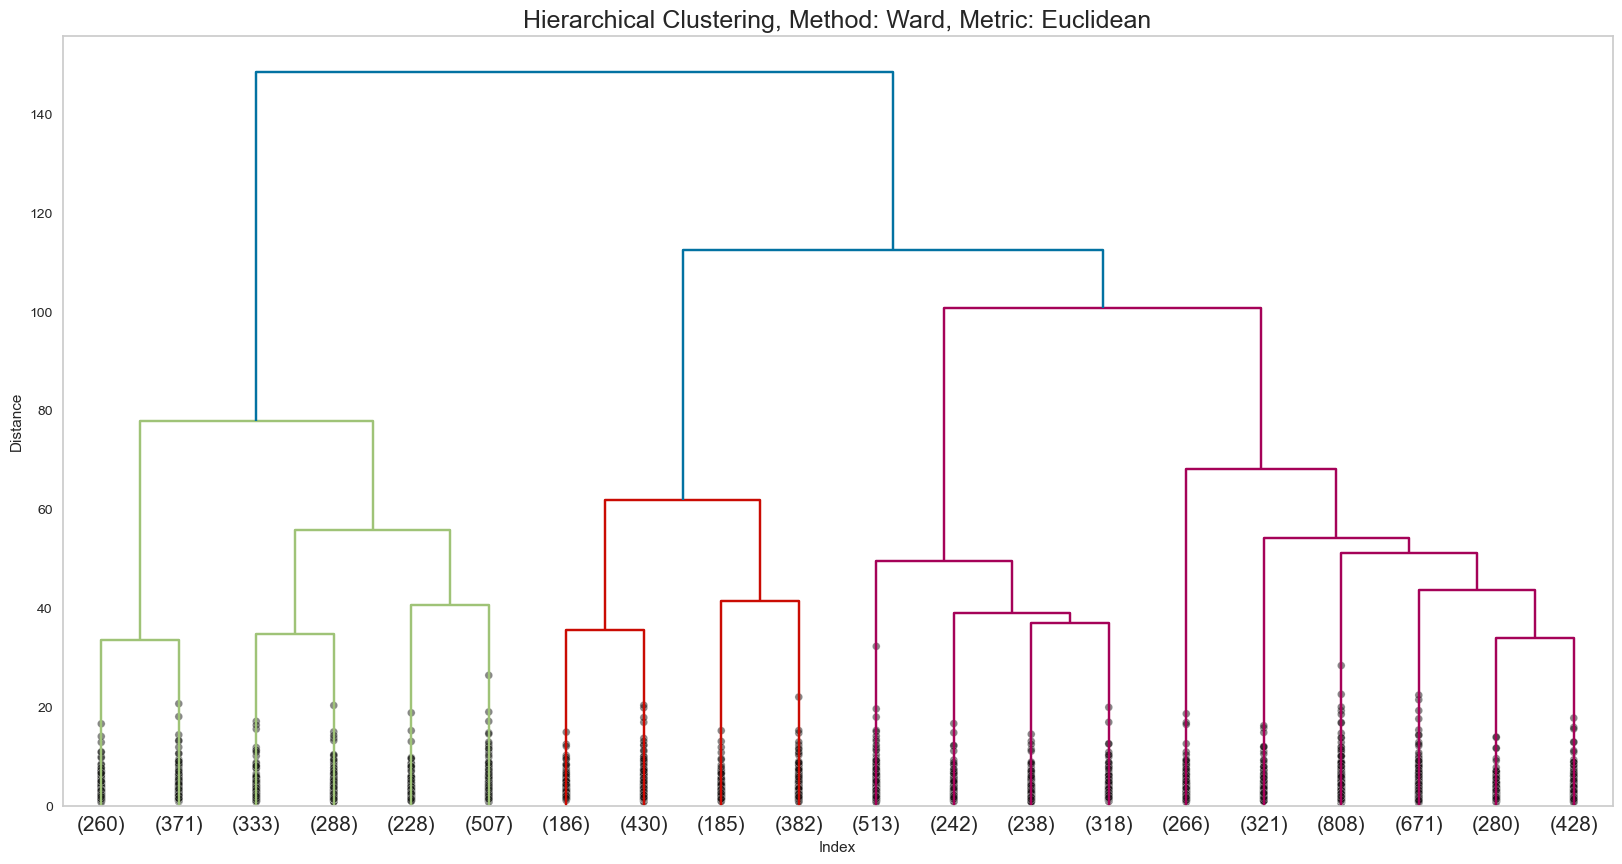

In [28]:
hiercluster('ward', 'euclidean')

There is a large distance between around 141 and 110, which indicates 2 clusters for Ward. Now we'll see if any other method/metric performs better.

Average linkage and euclidean metric:

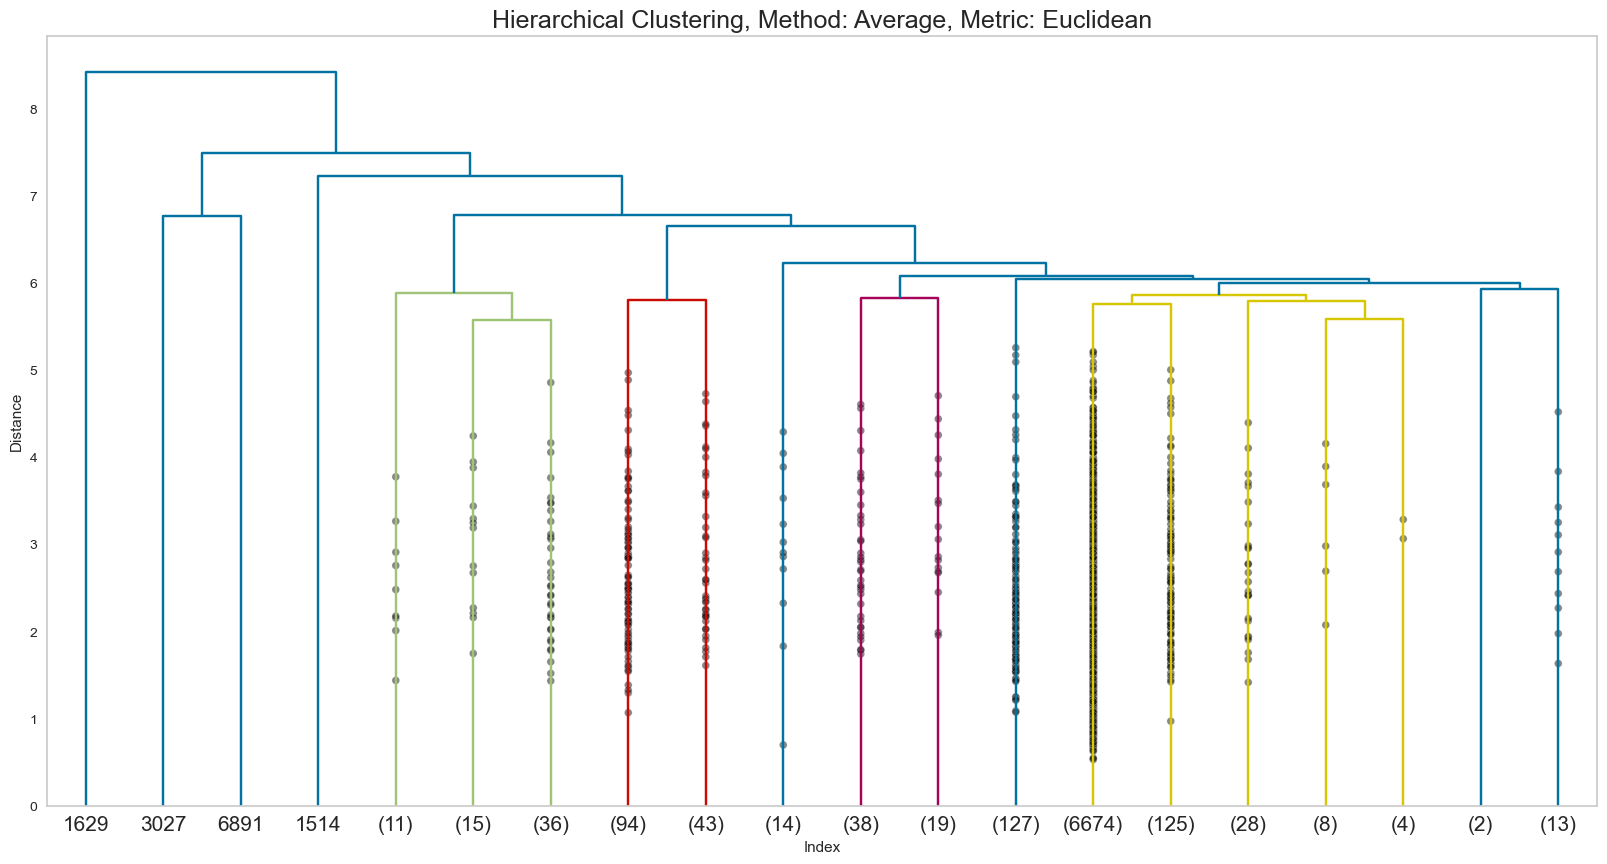

In [29]:
hiercluster('average', 'euclidean')

Even though average and euclidean had a high silhouette score, the dendrogram does not look good, especially compared to ward. The distance is not as large.

Average linkage and correlation metric:

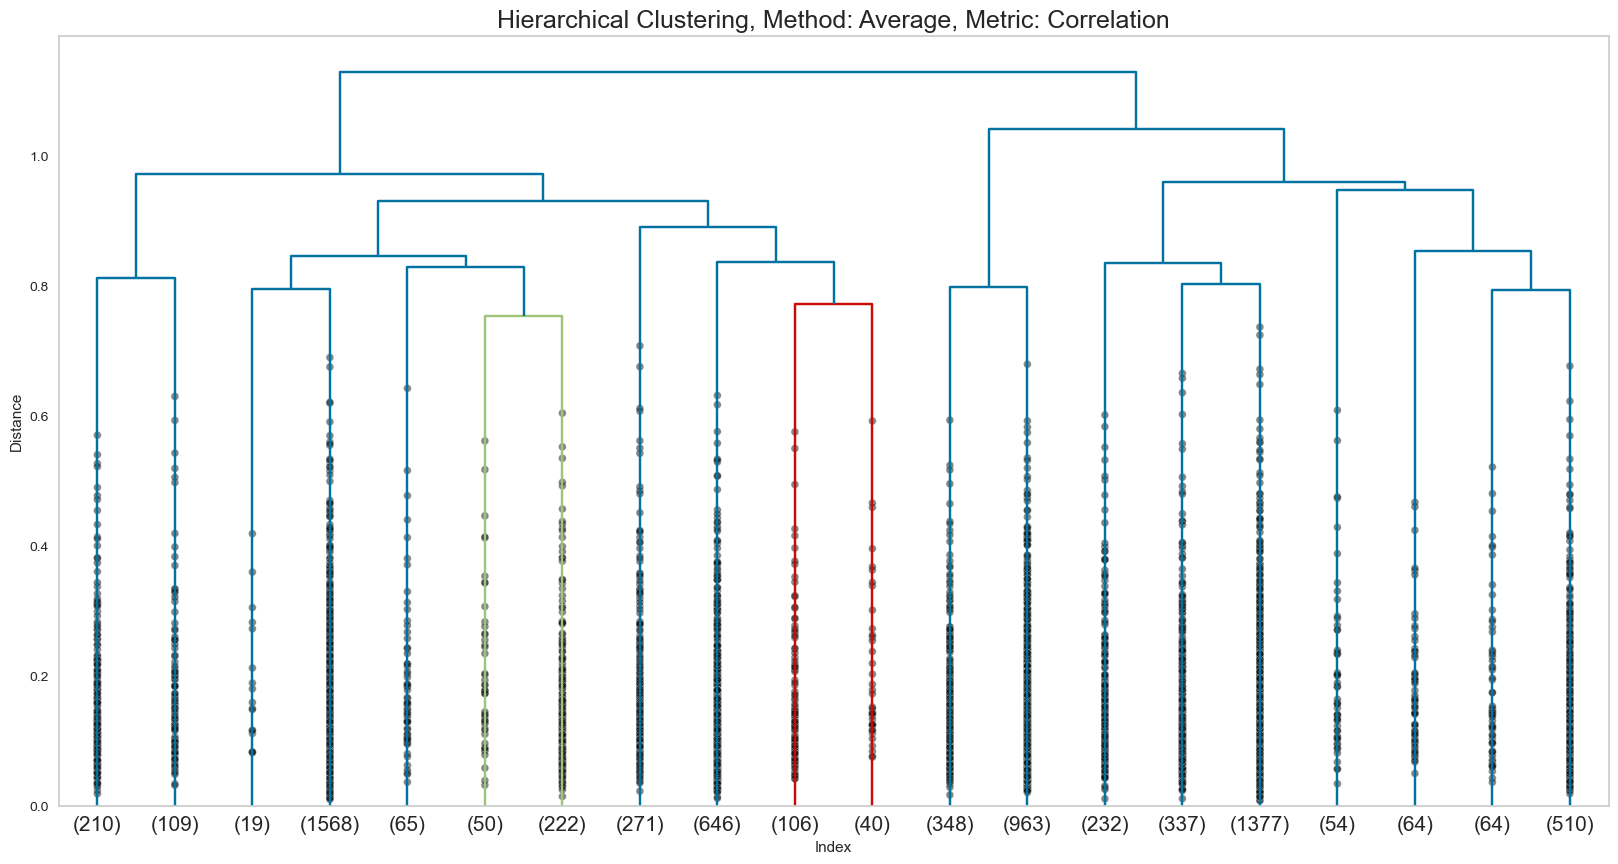

In [30]:
hiercluster('average', 'correlation')

Average and correlation do not perform well in terms of silhouette score nor distance, especially compared to ward.

Average linkage and cosine metric:

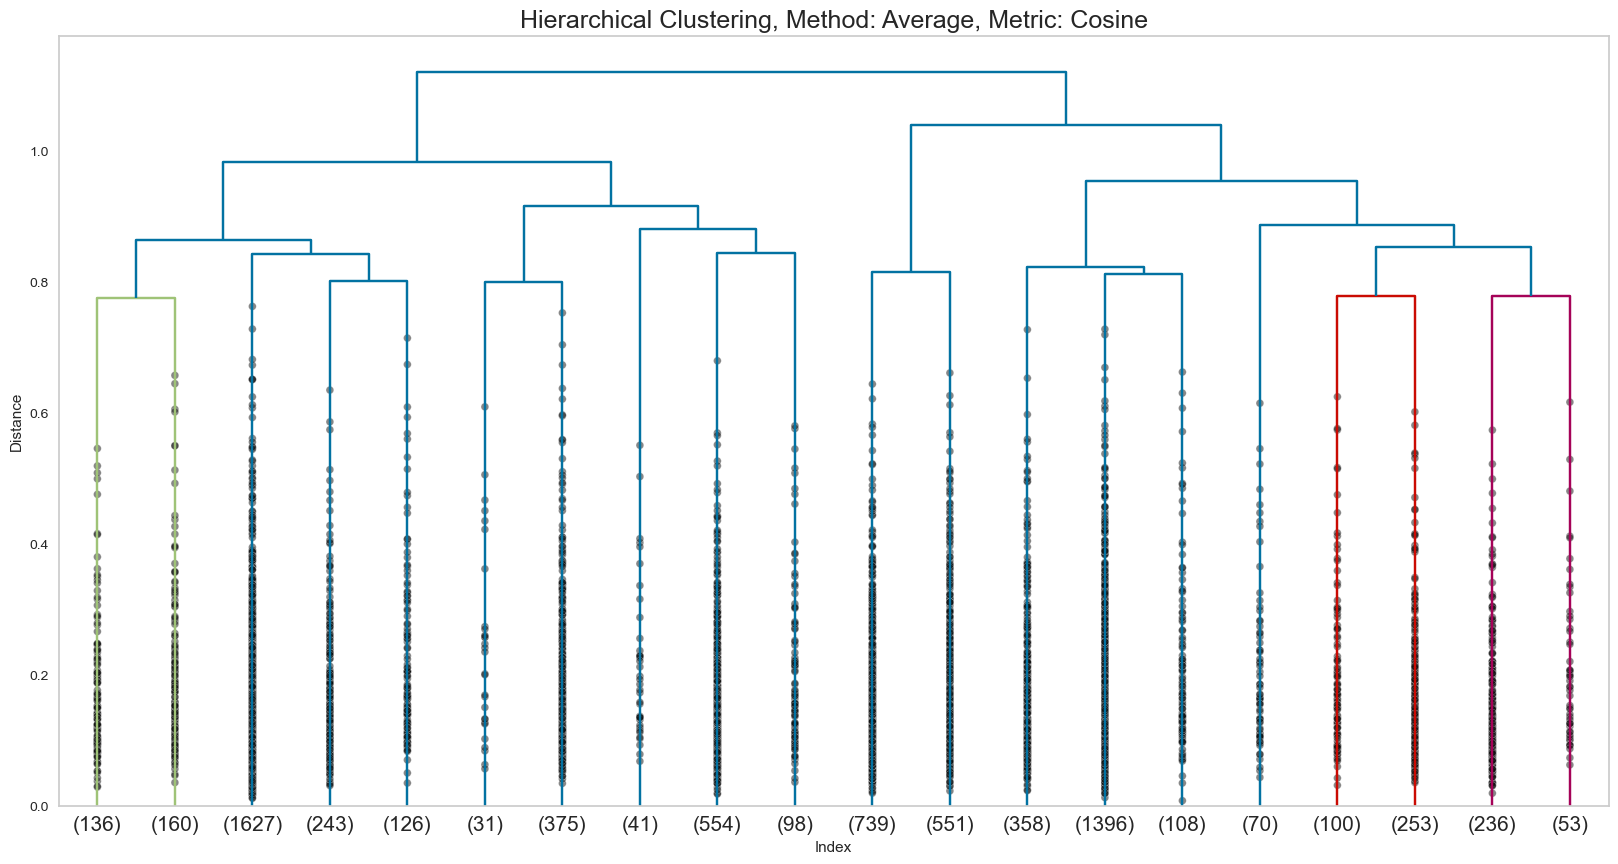

In [31]:
hiercluster('average', 'cosine')

Average and cosine do not perform well in terms of silhouette score nor distance, especially compared to ward.

Average linkage and minkowski metric:

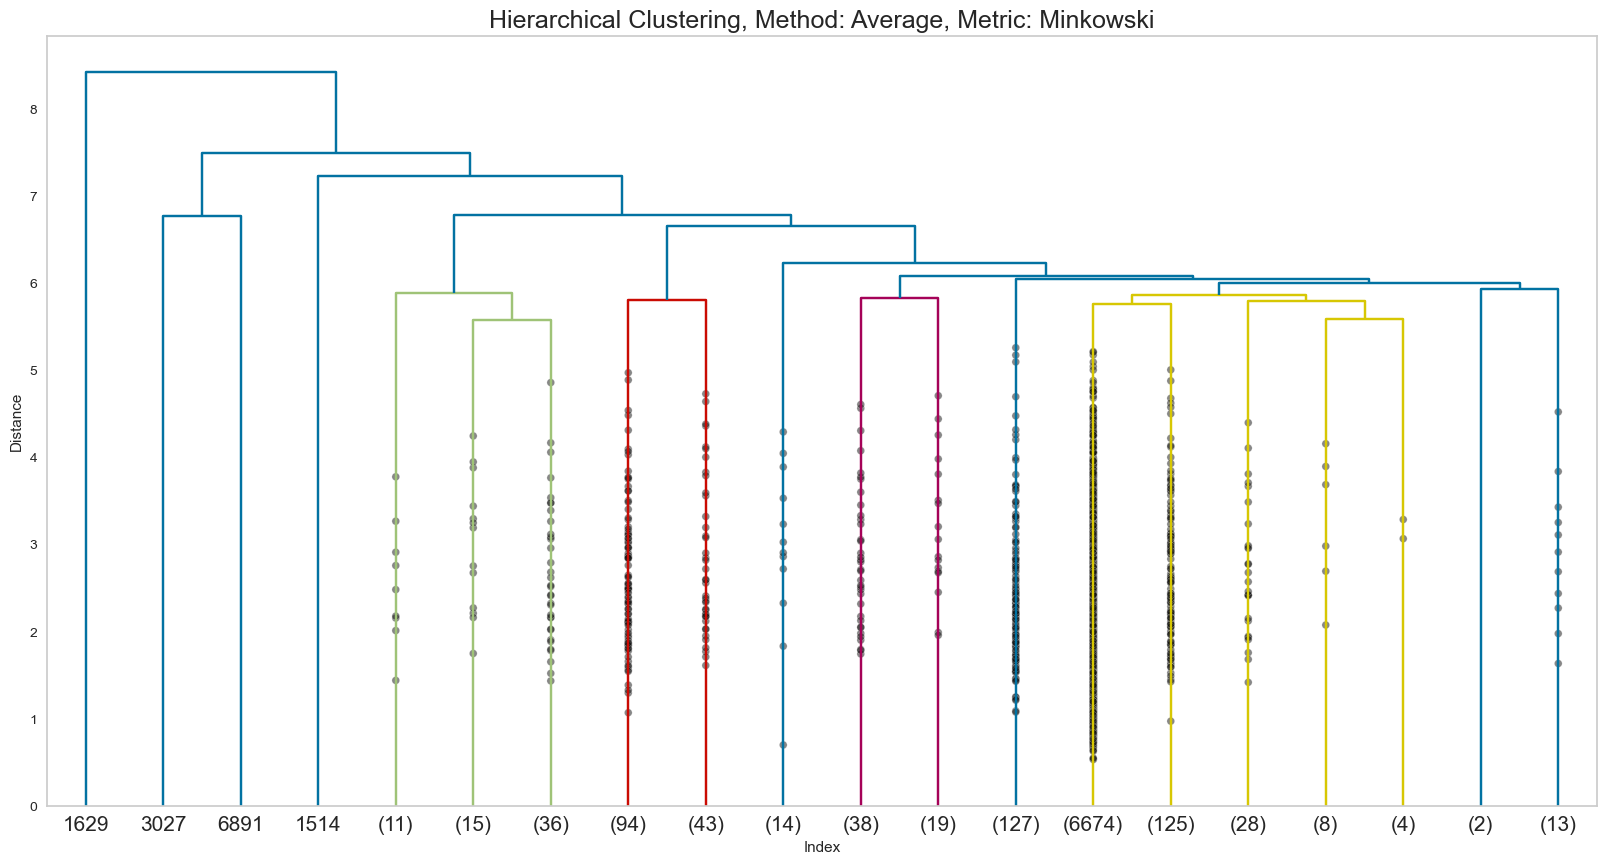

In [32]:
hiercluster('average', 'minkowski')

Even though average and minkowski had a high silhouette score, the dendrogram does not look good, especially compared to ward. The distance is not as large.

Complete linkage and euclidean metric:

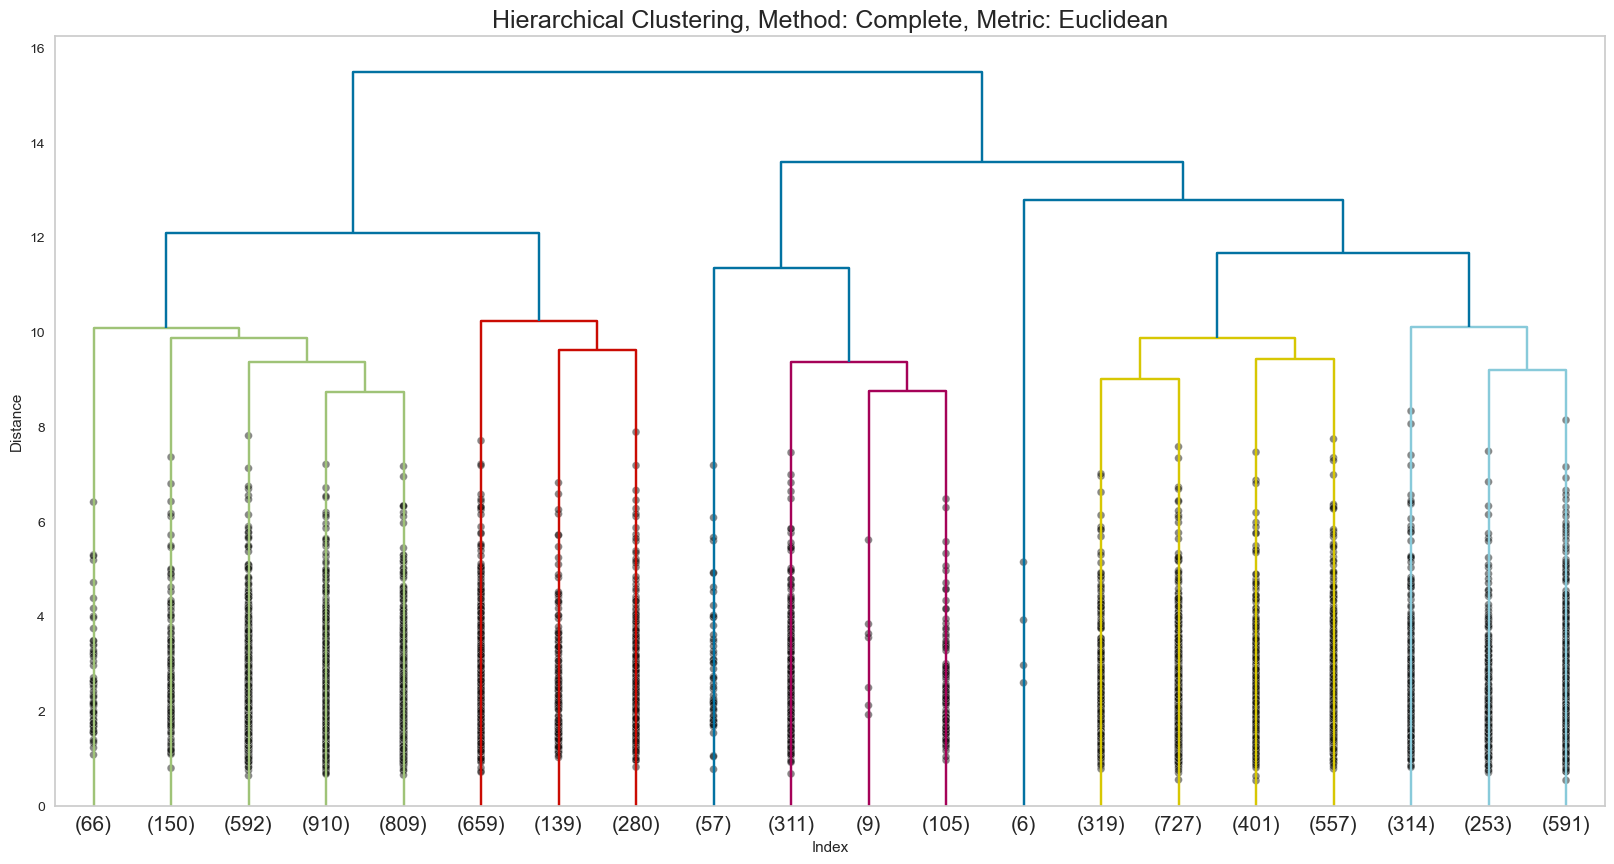

In [33]:
hiercluster('complete', 'euclidean')

Complete and euclidean do not perform well in terms of silhouette score nor distance, especially compared to ward.

Complete linkage and correlation metric:

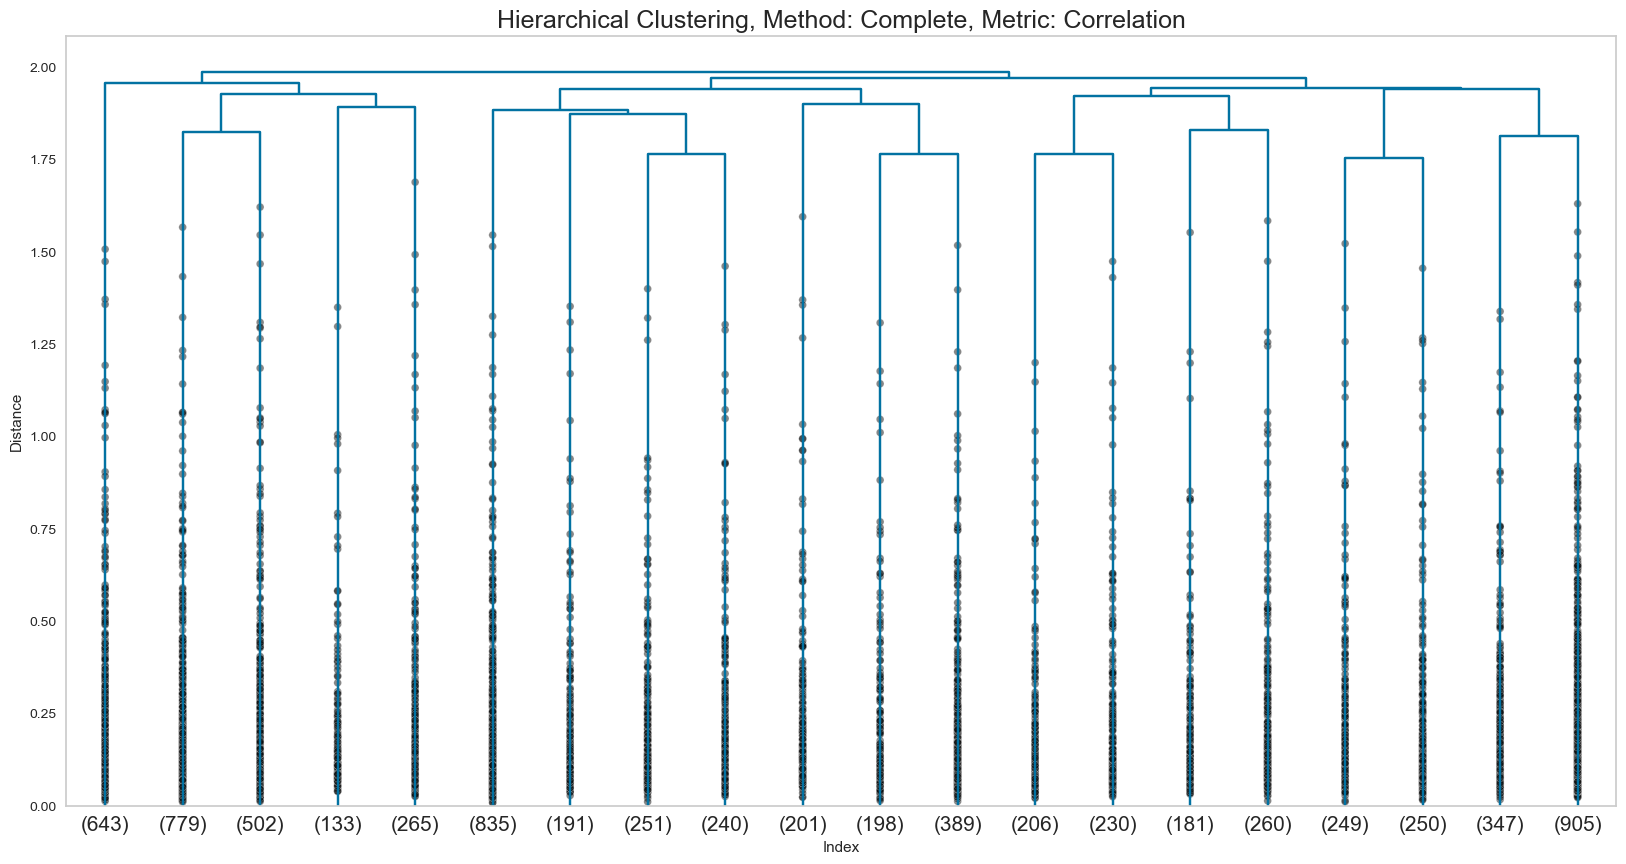

In [34]:
hiercluster('complete', 'correlation')

Complete and correlation do not perform well in terms of silhouette score nor distance, especially compared to ward.

Complete linkage and cosine metric:

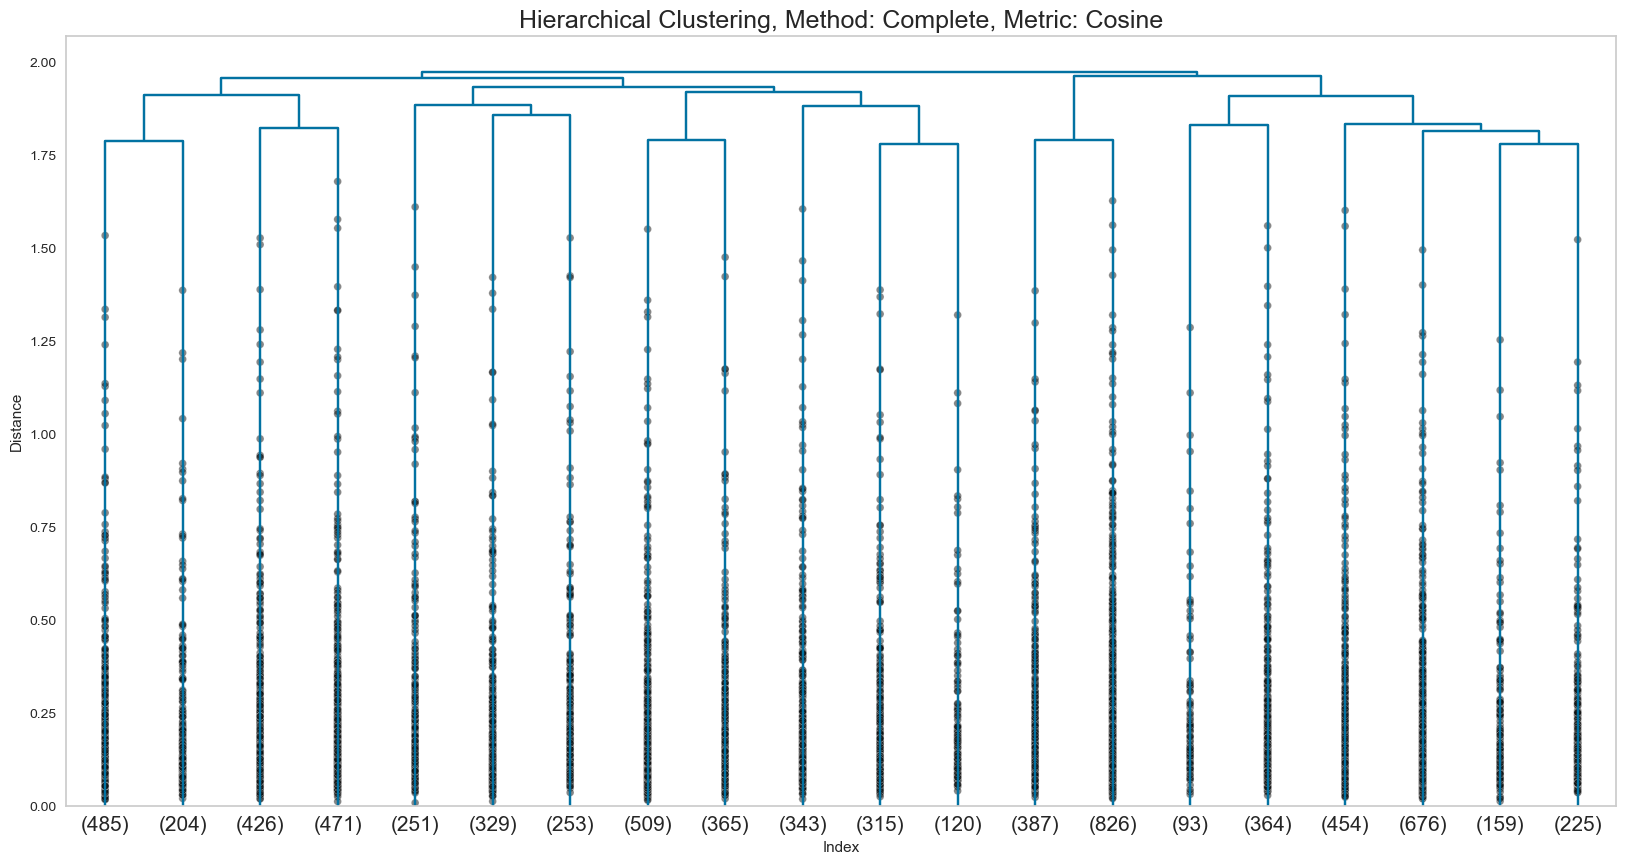

In [35]:
hiercluster('complete', 'cosine')

Complete and cosine do not perform well in terms of silhouette score nor distance, especially compared to ward.

Complete linkage and minkowski metric:

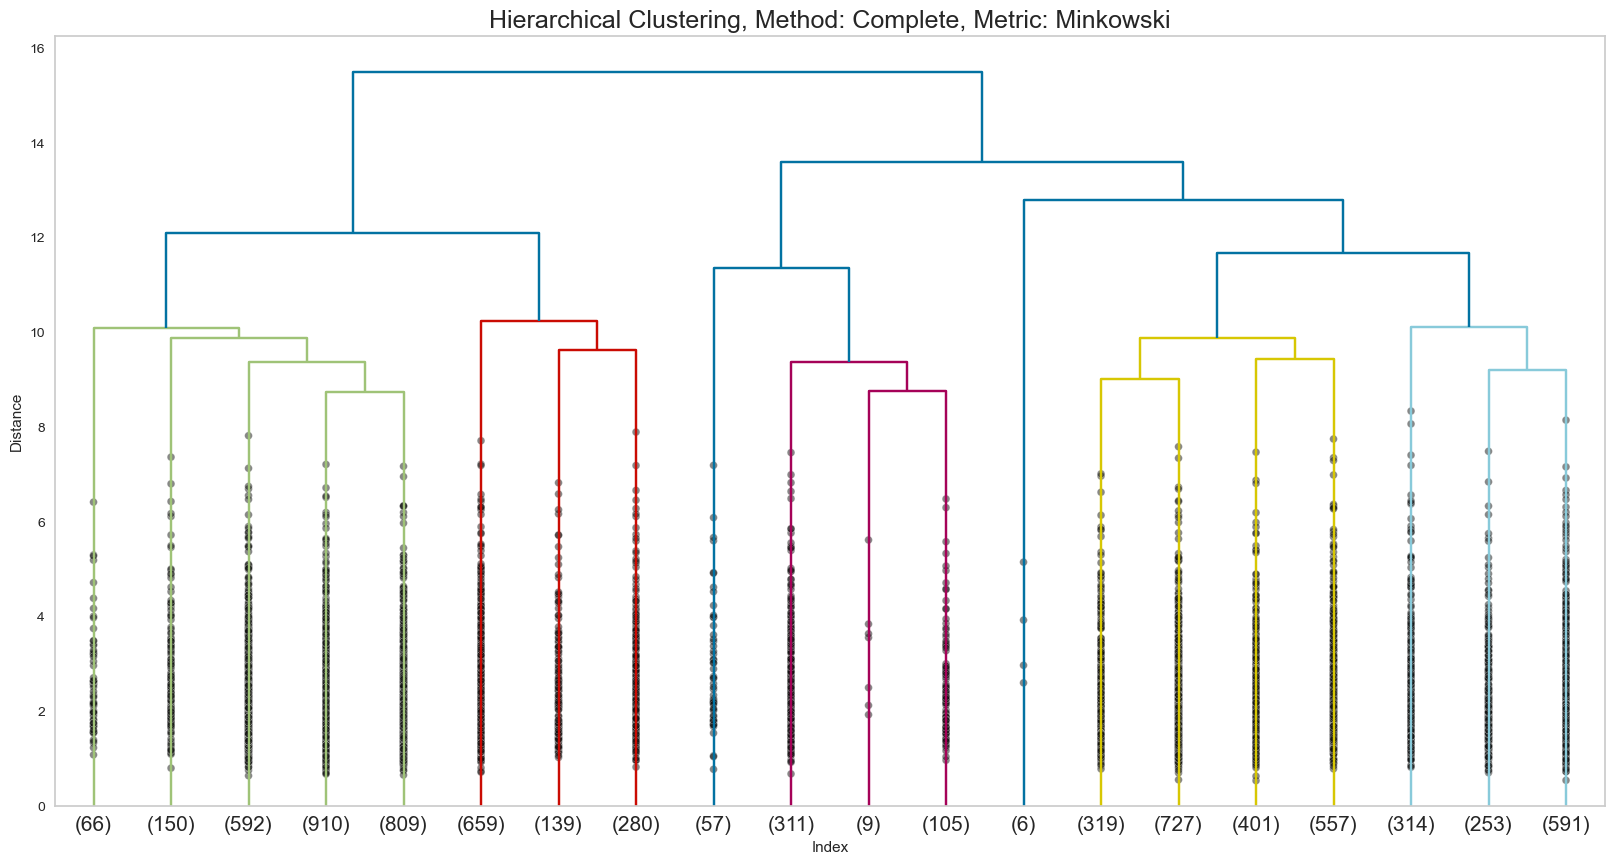

In [36]:
hiercluster('complete', 'minkowski')

Plotting the single linkage creates problems and the kernel usually dies. This is because single has a chaining problem and, due to the composition of the data, the dendrogram does not provide any useful insight. Therefore, we comment out the code to avoid the kernel dying.

In [37]:
#hiercluster('single', 'euclidean')

In [38]:
#hiercluster('single', 'correlation')

In [39]:
# hiercluster('single', 'cosine')

In [40]:
#hiercluster('single', 'minkowski')

**Best Model for HC: Ward with 2 Clusters** There is a large distance for 2 clusters, as shown by the dendrogram, and a decent silhouette score. Therefore, we move forward with this model as the best for hierarchical clustering to compare against other clustering methods.

In [41]:
# Instantiating best HC model
hc_ward = AgglomerativeClustering(linkage = 'ward', compute_distances = True, n_clusters = 2)

# Fitting data to HC model
hc_ward.fit(X)

AgglomerativeClustering(compute_distances=True)

Now that we've created the best HC model, we'll create a dataframe called `results_hc` to determine which row corresponds to each cluster. This way, we can easily look at and visualize the results of the HC model.

In [42]:
# Combining original df with feature names and transformed df with principal components
results_hc = pd.concat([X_copy.reset_index(drop = True), pd.DataFrame(X)], axis = 1)

# Creating a new column for each row to indicate its cluster
results_hc['Segment_HC'] = hc_ward.labels_

# Creating a new column to rename clusters as First and Second in place of 0 and 1
results_hc['Cluster'] = results_hc['Segment_HC'].map({0 : 'First', 1: 'Second'})

# Printing first five rows
results_hc.head()

Ast_per_game  Blk_per_game  DR_per_game       FG%      FG3%       FT%  \
0      0.037876     -1.251867    -3.411210  1.660529  1.297951 -1.209660   
1      1.056053     -1.251867    -1.836602  2.041626 -0.092757  1.072969   
2     -0.511689      0.695282     0.184077 -0.612826 -0.792304  0.281999   
3      1.056053     -1.251867    -0.313566 -1.365254  0.603939  0.281999   
4     -0.511689     -0.176502     0.184077 -0.612826  0.255937 -1.209660   

   OR_per_game  PF_per_game       PPG  Road_Wins  ...       PC4       PC5  \
0    -3.027137     0.299997 -2.189919  -0.905769  ... -1.749236  1.097065   
1    -0.288553     0.773974  1.624737  -0.549829  ... -0.674650  0.431873   
2     1.730477    -0.127217 -0.082377  -0.549829  ...  0.356705  0.990077   
3     1.730477     0.773974  0.434062  -1.303446  ...  0.340161 -1.428448   
4     0.705334    -0.127217 -0.952006  -0.223964  ... -0.139300  0.437904   

        PC6       PC7       PC8       PC9      PC10      PC11  Segment_HC  \
0 -1.324573 -2.437166 -0.027351 -1.960824 -0.628775 -1.444588           0   
1 -1.130778  0.522751  0.406801  0.755548 -0.740246 -0.517249           1   
2  0.094410  1.369759 -0.236406  0.088466 -0.565858  0.725095           0   
3  0.736689 -0.274370  1.099428  1.767266 -0.329541  1.500155           0   
4 -0.466764 -0.951828 -0.062262  0.140524  1.081907  0.575832           0   

   Cluster  
0    First  
1   Second  
2    First  
3    First  
4    First  

[5 rows x 28 columns]

Now, let's look at the results of the ward HC and how it clustered the data with respect to the principal components. (Later in the notebook we'll look at actual features.)

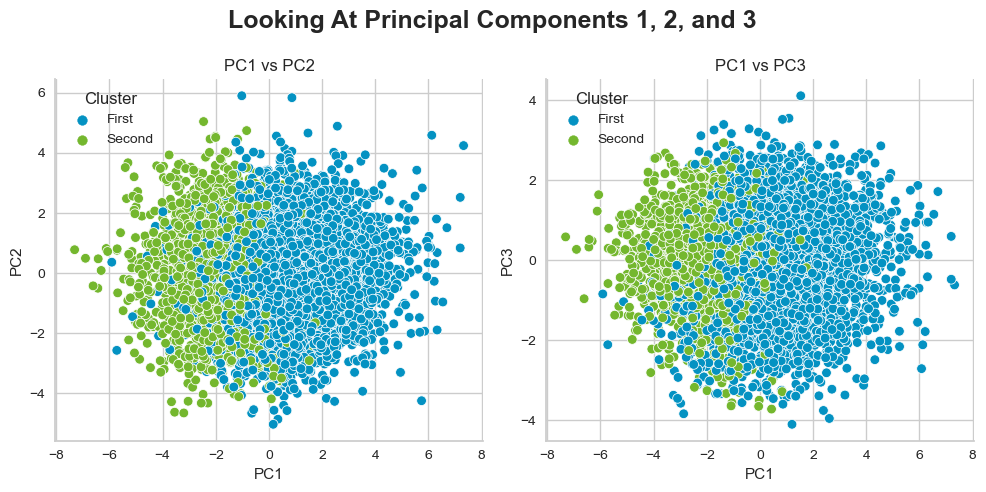

In [43]:
# Initializing subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creating for loop to plot each PC
sns.scatterplot(data = results_hc, x = "PC1", y = 'PC2', hue = 'Cluster', palette = palette_2_clusters, 
               hue_order = ['First', 'Second'], ax = ax[0])
sns.scatterplot(data = results_hc, x = "PC1", y = 'PC3', hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], ax = ax[1])

# Setting title
ax[0].set_title('PC1 vs PC2')
ax[1].set_title('PC1 vs PC3')

# Main title and other style edits
plt.suptitle('Looking At Principal Components 1, 2, and 3', fontsize = 18, fontweight='bold')
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

Whereas KMeans had a clear cut down the middle of the data to divide into cluster 1 and 2, the ward HC doesn't have a clear delineation. The left side still seems to be one cluster whereas the right side is another but there is confusion and overlap in the clustering.

Next, we'll look at boxplots for the first 4 principal components.

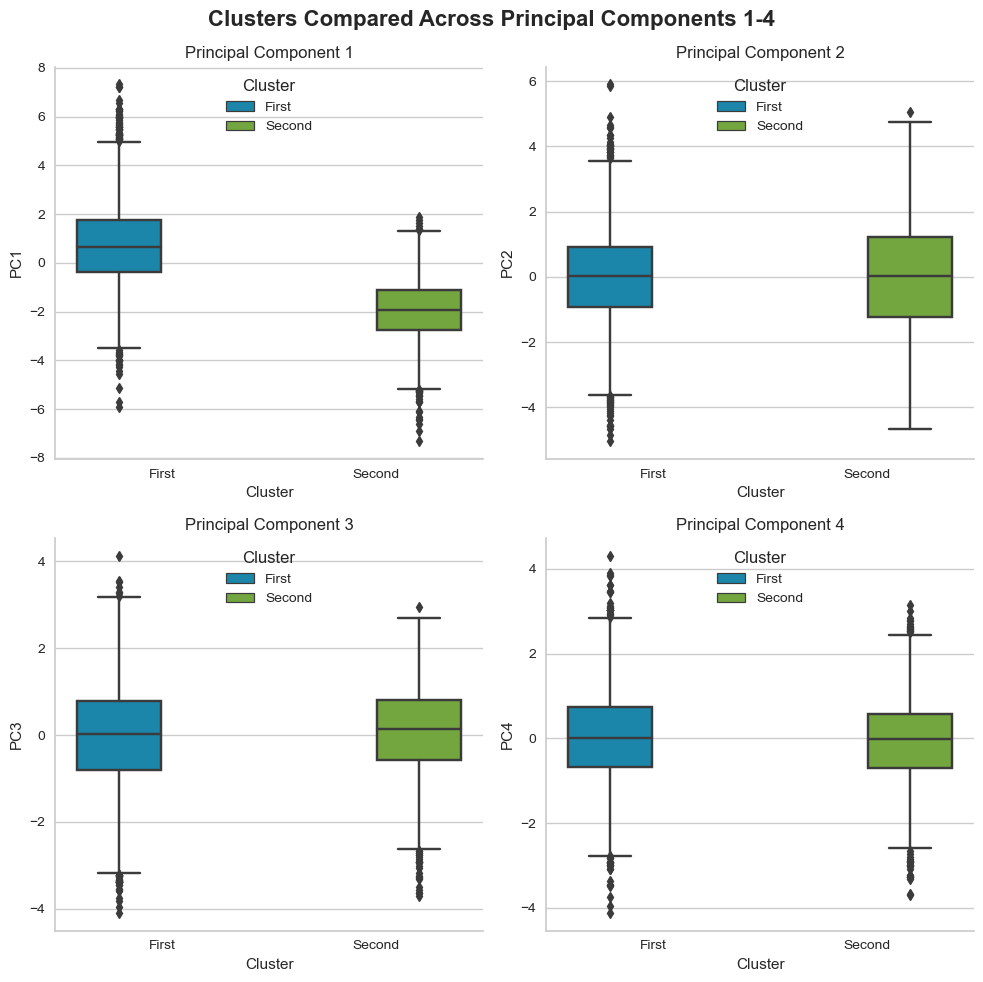

In [44]:
# Initializing subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Creating for loop to plot each PC
sns.boxplot(data = results_hc, x = "Cluster", y = 'PC1', ax = ax[0, 0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])
sns.boxplot(data = results_hc, x = "Cluster", y = 'PC2', ax = ax[0, 1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])
sns.boxplot(data = results_hc, x = "Cluster", y = 'PC3', ax = ax[1, 0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])
sns.boxplot(data = results_hc, x = "Cluster", y = 'PC4', ax = ax[1, 1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])

# Setting title
ax[0, 0].set_title('Principal Component 1')
ax[0, 1].set_title('Principal Component 2')
ax[1, 0].set_title('Principal Component 3')
ax[1, 1].set_title('Principal Component 4')

# Setting legend location
ax[0, 0].legend(loc='upper center', title = 'Cluster')
ax[0, 1].legend(loc='upper center', title = 'Cluster')
ax[1, 0].legend(loc='upper center', title = 'Cluster')
ax[1, 1].legend(loc='upper center', title = 'Cluster')

# Main title and other style edits
plt.suptitle('Clusters Compared Across Principal Components 1-4', fontsize = 16, fontweight='bold')
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

The Principal Component Boxplots to for Principal Components 1-4 shows us that the differentiation between the two clusters is most apparent for Principal Component 1. We see that the interquartile range for Cluster 1 is higher than Cluster 2's IQR. For PC2, the IQR is larger for the second cluster than the first. The clusters level off for PC3 and PC4 as shown by the 2 bottom boxplots. We see more outliers in PC4.

Finally, we'll look at a 3D plot to look at Principal Components 1, 2, and 3 together.

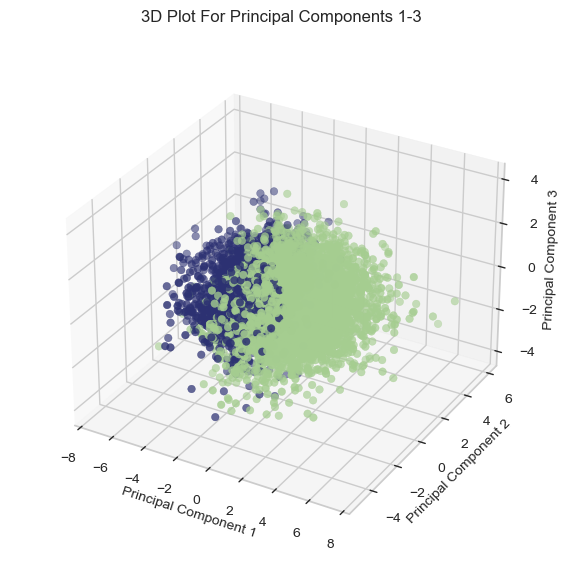

In [45]:
# Setting 3D Figure
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Specifying x and y axes
x = np.array(results_hc['PC1'])
y = np.array(results_hc['PC2'])
z = np.array(results_hc['PC3'])

# Setting axes labels
ax.set_xlabel('Principal Component 1', fontsize=10, rotation=150)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10, rotation=90)

# Plotting scatterplot
ax.scatter(x,y,z, c = results_hc["Segment_HC"], s=30, cmap = "crest")

# Setting title
plt.title('3D Plot For Principal Components 1-3')

# Scaling plot
ax.set_box_aspect(None, zoom=0.9)
plt.tight_layout()

The 3-D plot displays similar information that we saw in the 2D plot. There is somewhat of a divide between cluster 1 and 2 but the cut/divide is not very clear.

## Gaussian Mixture Model

There are multiple ways to determine the best Gaussian Mixture Model. In this section we'll look at BIC and the silhouette score (to be consistent across all models). We will use both metrics to make an informed decision on how to tune the GMM.

Below, we create a function to use in the GridSearchCV to return the best BIC score.

In [46]:
# Creating a function to use to pass through the GridSearchCV
def gmm_bic_score(estimator, X):
    
    # Making BIC negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

Now, we'll pass GMM through the `GridSearchCV`.

In [47]:
# Choosing parameters to enter in GridSearchCV
param_grid = {"n_components": range(1, 7), "covariance_type": ["spherical", "tied", "diag", "full"]}

# Instantiating GridSearchCV model
grid_search = GridSearchCV(GaussianMixture(random_state = seed), param_grid = param_grid, scoring = gmm_bic_score)

# Fitting data to the model
grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(random_state=12),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x0000028901EDAA60>)

Now that we've fitted the `GridSearchCV` to the data. Let's look at the results below.

In [48]:
# Creating a dataframe to look at the metric results from GridSearchCV
gmm_metrics = pd.DataFrame(grid_search.cv_results_)[["param_n_components", "param_covariance_type", "mean_test_score"]]

# Making the mean test score negative
gmm_metrics["mean_test_score"] = -gmm_metrics["mean_test_score"]

# Renaming the columns
gmm_metrics = gmm_metrics.rename(columns={"param_n_components": "Number of components",
                                          "param_covariance_type": "Type of covariance", 
                                          "mean_test_score": "BIC score"})

# Sorting to get values with top 3 BIC scores
gmm_metrics.sort_values(by="BIC score").head(3)

Number of components Type of covariance     BIC score
20                    3               full  40398.042936
19                    2               full  40439.781271
21                    4               full  40792.255358

It looks like 'full' covariance performed best. The top number of components (or clusters) are 3, 2, and 4. However, the difference in BIC scores are not large.

Let's look at a plot of the BIC score to see how it varies for different cluster numbers.

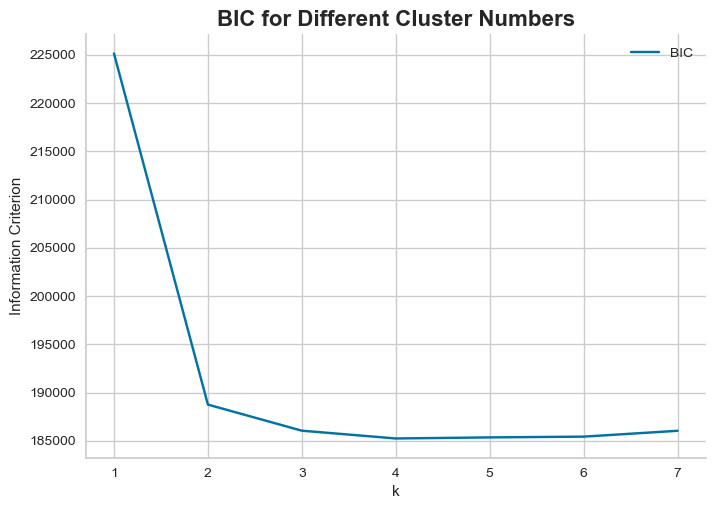

In [49]:
# Creating a list of BIC scores
sum_bic = []

# Setting range of cluster numbers
K = range(1, 8)

# For loop to iterate through different cluster numbers
for k in K:
    
    # Instantiating GMM model for different cluster numbers
    gmm = GaussianMixture(n_components = k, covariance_type = 'full', random_state = seed)
    
    # Fitting data to model
    gmm = gmm.fit(X)
    
    # Appending BIC score to list
    sum_bic.append(gmm.bic(X))
    
    
# Setting x and y axes for plot
x = K
y = sum_bic

# Plotting the data
plt.plot(x, y, label = "BIC")

# Setting titles, legends, and style of plot
plt.title("BIC for Different Cluster Numbers", fontsize = 16, fontweight='bold')
plt.xlabel("k")
plt.ylabel("Information Criterion")
plt.legend(loc='upper right')
sns.set_style('whitegrid')
sns.despine()
plt.show()

Overall, BIC scores suggest that 3 clusters are best. 

Now that we've looked at the BIC score, let's see if the silhouette score corroborates our findings of 3 clusters.

In [50]:
# Creating a list to get all silhouette scores and number of clusters
silhouette_scores = [] 
num = []

# Iterating through range of different clusters
for n in range(2, 8):
    
    # Appending silhouette scores and number of clusters
    silhouette_scores.append(silhouette_score(X, GaussianMixture(n_components = n, random_state = seed).fit_predict(X)))
    num.append(n)

# Creating a df with silhouette score results
gmm_sil = pd.DataFrame({'Number of Clusters' : num, 'Silhouette_Score' : silhouette_scores})

# Printing results with best score first
gmm_sil.sort_values(by = 'Silhouette_Score', ascending = False)

Number of Clusters  Silhouette_Score
0                   2          0.118096
1                   3          0.056635
2                   4          0.047900
4                   6          0.017579
3                   5          0.011408
5                   7         -0.014094

The dataframe above indicates that 2 clusters are the best because there silhouette score is the largest at 0.118096.

Because the difference between 2 and 3 clusters is significant, this might suggest that 2 clusters are better. How do we reconcile the 2 clusters with the 3 suggested by the BIC? The difference is more significant between 2 and 3 for silhouette scores than that of BIC. Also, since the project mainly relies on silhouette scores, we'll use its results to stay consistent across models.

**Best Model for GMM: 2 Clusters & Covariance Type Full**

In [51]:
# Instantiating Best Model for GMM
gmm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state = seed)

# Fitting model to data
gmm.fit(X)

GaussianMixture(n_components=2, random_state=12)

Below, we create a dataframe called `results_gmm` with the results of the cluster so that every row from the data `X` is assigned its correct cluster according to GMM. The dataframe will be used for visualizing results.

In [52]:
# Combining original df with feature names and transformed df with principal components
results_gmm = pd.concat([X_copy.reset_index(drop = True), pd.DataFrame(X)], axis = 1)

# Creating a new column for each row to indicate its cluster
results_gmm['Segment_GMM'] = gmm.predict(X)

# Creating a new column to rename clusters as First and Second in place of 0 and 1
results_gmm['Cluster'] = results_gmm['Segment_GMM'].map({0 : 'First', 1: 'Second'})

# Printing first five rows of df
results_gmm.head()

Ast_per_game  Blk_per_game  DR_per_game       FG%      FG3%       FT%  \
0      0.037876     -1.251867    -3.411210  1.660529  1.297951 -1.209660   
1      1.056053     -1.251867    -1.836602  2.041626 -0.092757  1.072969   
2     -0.511689      0.695282     0.184077 -0.612826 -0.792304  0.281999   
3      1.056053     -1.251867    -0.313566 -1.365254  0.603939  0.281999   
4     -0.511689     -0.176502     0.184077 -0.612826  0.255937 -1.209660   

   OR_per_game  PF_per_game       PPG  Road_Wins  ...       PC4       PC5  \
0    -3.027137     0.299997 -2.189919  -0.905769  ... -1.749236  1.097065   
1    -0.288553     0.773974  1.624737  -0.549829  ... -0.674650  0.431873   
2     1.730477    -0.127217 -0.082377  -0.549829  ...  0.356705  0.990077   
3     1.730477     0.773974  0.434062  -1.303446  ...  0.340161 -1.428448   
4     0.705334    -0.127217 -0.952006  -0.223964  ... -0.139300  0.437904   

        PC6       PC7       PC8       PC9      PC10      PC11  Segment_GMM  \
0 -1.324573 -2.437166 -0.027351 -1.960824 -0.628775 -1.444588            1   
1 -1.130778  0.522751  0.406801  0.755548 -0.740246 -0.517249            1   
2  0.094410  1.369759 -0.236406  0.088466 -0.565858  0.725095            1   
3  0.736689 -0.274370  1.099428  1.767266 -0.329541  1.500155            0   
4 -0.466764 -0.951828 -0.062262  0.140524  1.081907  0.575832            1   

   Cluster  
0   Second  
1   Second  
2   Second  
3    First  
4   Second  

[5 rows x 28 columns]

Now, let's look at the results of the GMM and how it clustered the data with respect to the principal components. (Later in the notebook we'll look at actual features.)

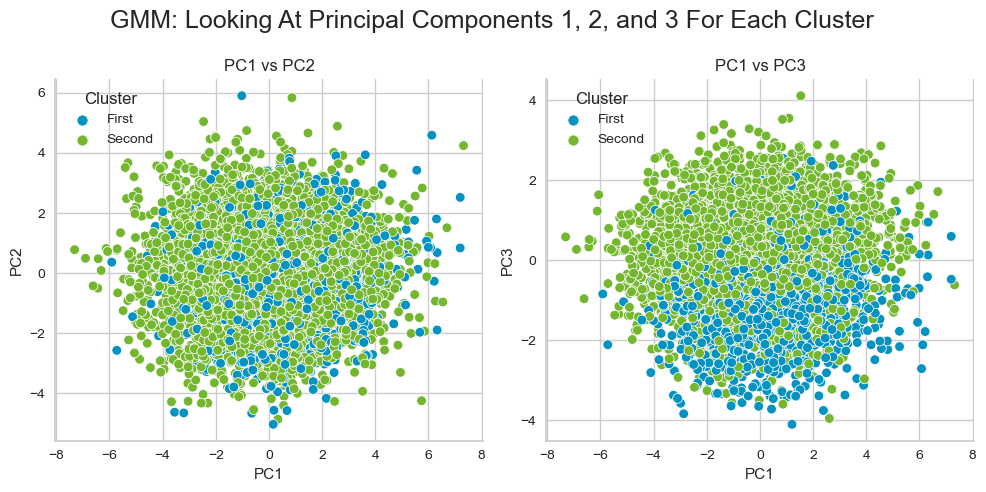

In [53]:
# Initializing subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creating for loop to plot each PC
sns.scatterplot(data = results_gmm, x = "PC1", y = 'PC2', hue = 'Cluster', palette = palette_2_clusters, 
               hue_order = ['First', 'Second'], ax = ax[0])
sns.scatterplot(data = results_gmm, x = "PC1", y = 'PC3', hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], ax = ax[1])

# Setting title
ax[0].set_title('PC1 vs PC2')
ax[1].set_title('PC1 vs PC3')

# Main title and other style edits
plt.suptitle('GMM: Looking At Principal Components 1, 2, and 3 For Each Cluster', fontsize = 18)
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

While KMeans and HC had somewhat of a clear difference in the clusters, the GMM does not perform as well. The plot for PC1 vs. PC3 has a slightly clearer delineation but overall does not perform as well as ward HC and especially KMeans.

Let's look at the boxplots for the first four principal components.

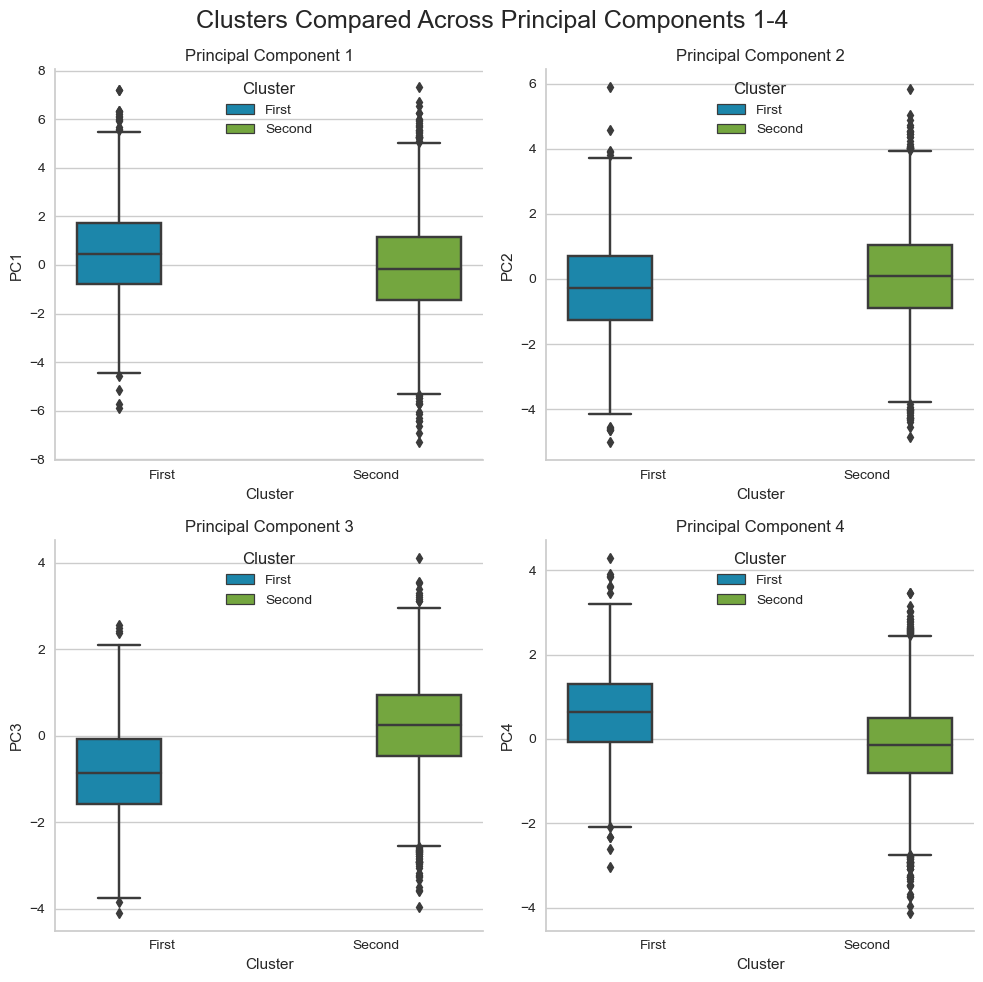

In [54]:
# Initializing subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Creating for loop to plot each PC
sns.boxplot(data = results_gmm, x = "Cluster", y = 'PC1', ax = ax[0, 0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])
sns.boxplot(data = results_gmm, x = "Cluster", y = 'PC2', ax = ax[0, 1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])
sns.boxplot(data = results_gmm, x = "Cluster", y = 'PC3', ax = ax[1, 0], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])
sns.boxplot(data = results_gmm, x = "Cluster", y = 'PC4', ax = ax[1, 1], hue = 'Cluster', palette = palette_2_clusters, 
                    hue_order = ['First', 'Second'], order = ['First', 'Second'])

# Setting title
ax[0, 0].set_title('Principal Component 1')
ax[0, 1].set_title('Principal Component 2')
ax[1, 0].set_title('Principal Component 3')
ax[1, 1].set_title('Principal Component 4')

# Setting legend location
ax[0, 0].legend(loc='upper center', title = 'Cluster')
ax[0, 1].legend(loc='upper center', title = 'Cluster')
ax[1, 0].legend(loc='upper center', title = 'Cluster')
ax[1, 1].legend(loc='upper center', title = 'Cluster')

# Main title and other style edits
plt.suptitle('Clusters Compared Across Principal Components 1-4', fontsize = 18)
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

Unlike the boxplots for KMeans and HC where we see the distributions level off after PC2, there are differences for each PC we see here. For PC1 and PC4, the first cluster's IQR is higher than the second's. For PC2 and 3, the IQR for the second cluster is higher. There is also a wider range for PC1 in GMM compared to PC1 in KMeans.

Finally, we'll look at a 3D plot to look at Principal Components 1, 2, and 3 together.

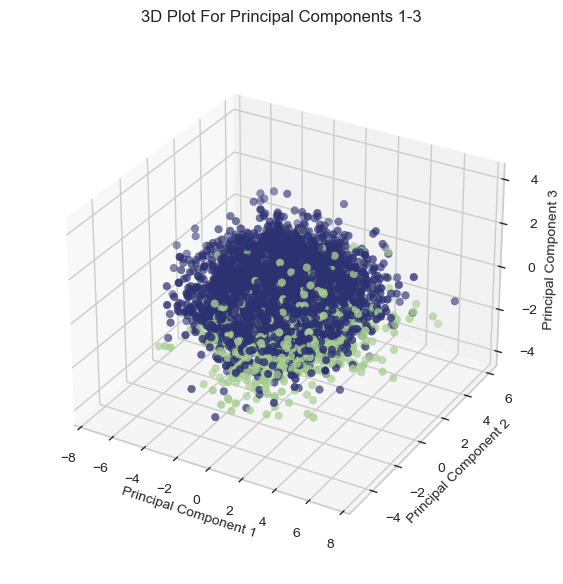

In [55]:
# Setting 3D Figure
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Specifying x and y axes
x = np.array(results_gmm['PC1'])
y = np.array(results_gmm['PC2'])
z = np.array(results_gmm['PC3'])

# Setting axes labels
ax.set_xlabel('Principal Component 1', fontsize=10, rotation=150)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10, rotation=90)

# Plotting scatterplot
ax.scatter(x,y,z, c = results_gmm["Segment_GMM"], s=30, cmap = "crest")

# Setting title
plt.title('3D Plot For Principal Components 1-3')

# Scaling plot
ax.set_box_aspect(None, zoom=0.9)
plt.tight_layout()

The 3-D plot displays similar information that we saw in the 2D plot. There is not a clear divide between cluster 1 and 2.

## DBSCAN

To determine the best epsilon value, we'll create a plot to find the best number. We'll use Sklearn's NearestNeighbors to get the estimated distance between the datapoints which can be used as eps in DBSCAN.

In [56]:
# Instantiating nearest neighbors model
nearest_neighbors = NearestNeighbors(n_neighbors = 10)

# Fitting data to model
neighbors = nearest_neighbors.fit(X)

# Getting the distances and indexes of neighbors
distances, indices = neighbors.kneighbors(X)

# Sorting distances
distances = np.sort(distances[:,9], axis=0)

We'll plot the distances to determine the best cutoff.

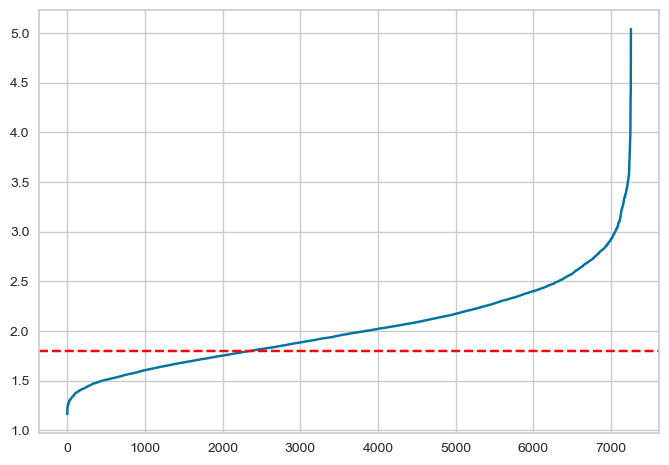

In [57]:
# Plotting the distances
plt.plot(distances)

# Indicating epsilon value cutoff
plt.axhline(y = 1.8, c = 'red', linestyle = '--')

We select an epsilon value of 1.8 to be the best. We'll use this `eps` and loop through other parameters (distance metrics, algorithms, and minimum samples per cluster) to determine the arrangement that gets the best silhouette score.

!!! THIS CODE MIGHT TAKE A FEW MINUTES TO RUN !!!

In [58]:
# Lists of relevant parameters to iterate through
min_samples = range(5, 15)
metrics = ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan']
algorithm = ['auto', 'kd_tree', 'ball_tree']

# Creating lists to append data to
scores = []
met = []
min_sample = []
alg = []

# Looping through parameters
for a in algorithm:
    for m in metrics:
        for ms in min_samples:
            
            # Instantiating DBSCAN model
            dbscan = DBSCAN(min_samples=ms, eps = 1.8, metric = m, algorithm = a)
            
            # Fitting data to model
            model = dbscan.fit(X)
            
            # Getting cluster labels
            labels = model.labels_
            
            # Removing noise
            if len(np.unique(labels)) > 1:
                score = silhouette_score(X, model.labels_) # getting silhouette score
                
                # Appending results to lists
                min_sample.append(ms)
                scores.append(score)
                met.append(m)
                alg.append(a)

Finding the best DBSCAN metrics (silhouette score), given the parameters passed through the for loop.

In [59]:
# Creating df with appended lists from for loop
dbscan_metrics = pd.DataFrame({'Min Samples' : min_sample, 'Metric' : met, 'Scores' : scores})

# Getting highest silhouette scores
dbscan_best = dbscan_metrics[dbscan_metrics.Scores == dbscan_metrics.Scores.max()]

# Printing results
dbscan_best

Min Samples     Metric    Scores
2             7  euclidean  0.034315
12            7         l2  0.034315
22            7  euclidean  0.034315
32            7         l2  0.034315
42            7  euclidean  0.034315
52            7         l2  0.034315

The best models are euclidean and l2, all with minimum samples of 7.

**Best model for DBSCAN:**

In [60]:
# Instantiating Best Model for DBSCAN
best_dbscan = DBSCAN(eps = 1.8, min_samples = 7, algorithm = 'auto', metric = 'euclidean')

# Fitting data to model
best_dbscan.fit(X)

# Getting cluster labels
clusters_dbscan = best_dbscan.labels_

Below, we create a dataframe called `results_dbscan` with the results of the cluster so that every row from the data `X` is assigned its correct cluster according to DBSCAN. The dataframe will be used for visualizing results.

In [61]:
# Combining original df with feature names and transformed df with principal components
results_dbscan = pd.concat([X_copy.reset_index(drop = True), pd.DataFrame(X)], axis = 1)

# Creating a new column for each row to indicate its cluster
results_dbscan['Segment_DBSCAN'] = best_dbscan.labels_


results_dbscan['Cluster'] = results_dbscan['Segment_DBSCAN'].map({-1 : 'Noise', 0: 'First', 1: 'Second'})

# Printing first five rows of results of KMeans
results_dbscan.head()

Ast_per_game  Blk_per_game  DR_per_game       FG%      FG3%       FT%  \
0      0.037876     -1.251867    -3.411210  1.660529  1.297951 -1.209660   
1      1.056053     -1.251867    -1.836602  2.041626 -0.092757  1.072969   
2     -0.511689      0.695282     0.184077 -0.612826 -0.792304  0.281999   
3      1.056053     -1.251867    -0.313566 -1.365254  0.603939  0.281999   
4     -0.511689     -0.176502     0.184077 -0.612826  0.255937 -1.209660   

   OR_per_game  PF_per_game       PPG  Road_Wins  ...       PC4       PC5  \
0    -3.027137     0.299997 -2.189919  -0.905769  ... -1.749236  1.097065   
1    -0.288553     0.773974  1.624737  -0.549829  ... -0.674650  0.431873   
2     1.730477    -0.127217 -0.082377  -0.549829  ...  0.356705  0.990077   
3     1.730477     0.773974  0.434062  -1.303446  ...  0.340161 -1.428448   
4     0.705334    -0.127217 -0.952006  -0.223964  ... -0.139300  0.437904   

        PC6       PC7       PC8       PC9      PC10      PC11  Segment_DBSCAN  \
0 -1.324573 -2.437166 -0.027351 -1.960824 -0.628775 -1.444588              -1   
1 -1.130778  0.522751  0.406801  0.755548 -0.740246 -0.517249               0   
2  0.094410  1.369759 -0.236406  0.088466 -0.565858  0.725095               0   
3  0.736689 -0.274370  1.099428  1.767266 -0.329541  1.500155              -1   
4 -0.466764 -0.951828 -0.062262  0.140524  1.081907  0.575832               0   

   Cluster  
0    Noise  
1    First  
2    First  
3    Noise  
4    First  

[5 rows x 28 columns]

Calculating the percent of rows that are in the second cluster.

In [62]:
# Calculating percent of rows determined to be noise
percent2 = len(results_dbscan[results_dbscan['Segment_DBSCAN'] == 1]) / len(results_dbscan)

# Printing results
print('The percent of rows determined to be Cluster 2 are %.2f' % (percent2 * 100) + '%')

The percent of rows determined to be Clsuter 2 are 0.07%


Unfortunately, this is likely too small of a number of datapoints to be in cluster 2 in order to pull any meaningful insights.

The DBSCAN model will assign points to a cluster or indicate the point as "noise." If the point is assigned -1, then DBSCAN determines it to be noise. Let's see how many points are noise.

In [63]:
# Calculating percent of rows determined to be noise
percent_noise = len(results_dbscan[results_dbscan['Segment_DBSCAN'] == -1]) / len(results_dbscan)

# Printing results
print('The percent of rows determined to be noise are %.2f' % (percent_noise * 100) + '%')

The percent of rows determined to be noise are 33.36%


In [64]:
# Creating filter to find rows that are not noise
no_noise = results_dbscan['Cluster'].isin(['First', 'Second'])

# Getting rows that are not noise
no_noise = results_dbscan[no_noise]

Now, let's look at the results of the DBSCAN and how it clustered the data with respect to the principal components. (Later in the notebook we'll look at actual features.)

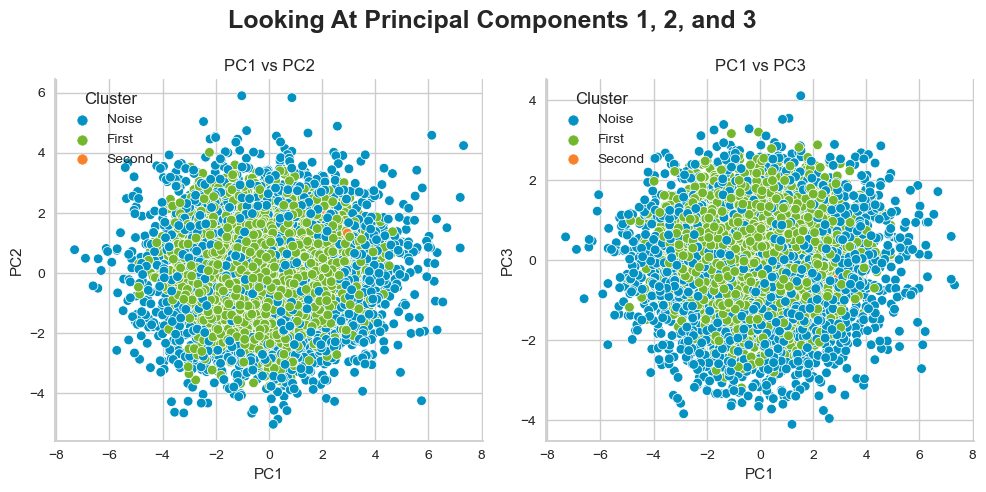

In [65]:
# Initializing subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creating for loop to plot each PC
sns.scatterplot(data = results_dbscan, x = 'PC1', y = 'PC2', hue = 'Cluster', hue_order = ['Noise', 'First', 'Second'], 
                palette = palette_3_clusters, ax = ax[0])
sns.scatterplot(data = results_dbscan, x = 'PC1', y = 'PC3', hue = 'Cluster', hue_order = ['Noise', 'First', 'Second'], 
                palette = palette_3_clusters, ax = ax[1])

# Setting title
ax[0].set_title('PC1 vs PC2')
ax[1].set_title('PC1 vs PC3')

# Main title and other style edits
plt.suptitle('Looking At Principal Components 1, 2, and 3', fontsize = 18, fontweight='bold')
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

As shown by the graphs, a large number of datapoints were indicated a noise, probably a few too many. In the PC1 vs PC2 plot, you can see one or two orange datapoints to indicate cluster 2. However, there are very few datapoints in cluster 2. Unfortunately, this creates some unevenness and confusing results with respect to the balance of noise, cluster 1, and cluster 2.

Let's look at the boxplots for the first four principal components.

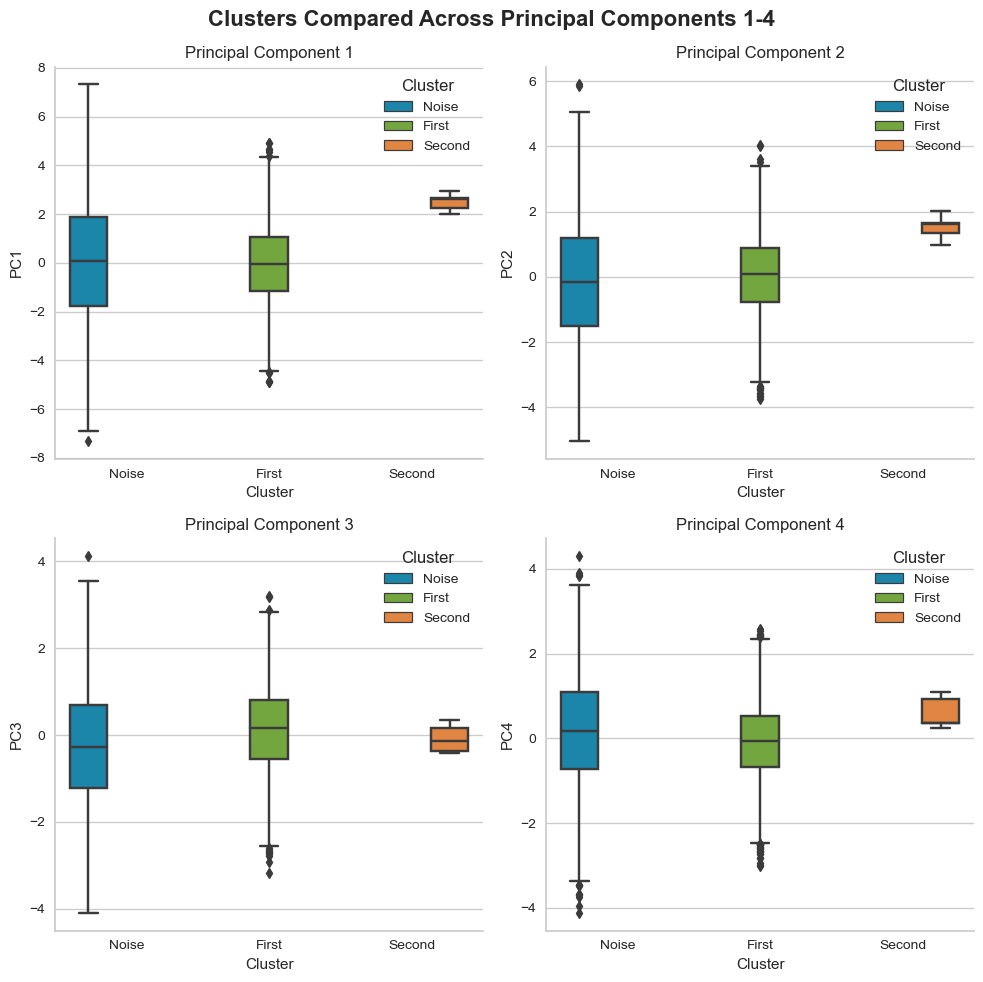

In [66]:
# Initializing subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Creating for loop to plot each PC
sns.boxplot(data = results_dbscan, x = "Cluster", y = 'PC1', ax = ax[0, 0], hue = 'Cluster', palette = palette_3_clusters, 
                    hue_order = ['Noise', 'First', 'Second'], order = ['Noise', 'First', 'Second'])
sns.boxplot(data = results_dbscan, x = "Cluster", y = 'PC2', ax = ax[0, 1], hue = 'Cluster', palette = palette_3_clusters, 
                    hue_order = ['Noise', 'First', 'Second'], order = ['Noise', 'First', 'Second'])
sns.boxplot(data = results_dbscan, x = "Cluster", y = 'PC3', ax = ax[1, 0], hue = 'Cluster', palette = palette_3_clusters, 
                    hue_order = ['Noise', 'First', 'Second'], order = ['Noise', 'First', 'Second'])
sns.boxplot(data = results_dbscan, x = "Cluster", y = 'PC4', ax = ax[1, 1], hue = 'Cluster', palette = palette_3_clusters, 
                    hue_order = ['Noise', 'First', 'Second'], order = ['Noise', 'First', 'Second'])

# Setting title
ax[0, 0].set_title('Principal Component 1')
ax[0, 1].set_title('Principal Component 2')
ax[1, 0].set_title('Principal Component 3')
ax[1, 1].set_title('Principal Component 4')

# Setting legend location
ax[0, 0].legend(loc='upper right', title = 'Cluster')
ax[0, 1].legend(loc='upper right', title = 'Cluster')
ax[1, 0].legend(loc='upper right', title = 'Cluster')
ax[1, 1].legend(loc='upper right', title = 'Cluster')

# Main title and other style edits
plt.suptitle('Clusters Compared Across Principal Components 1-4', fontsize = 16, fontweight='bold')
sns.set_style('whitegrid')        
sns.despine()
plt.tight_layout()

Finally, we'll look at a 3D plot to look at Principal Components 1, 2, and 3 together.

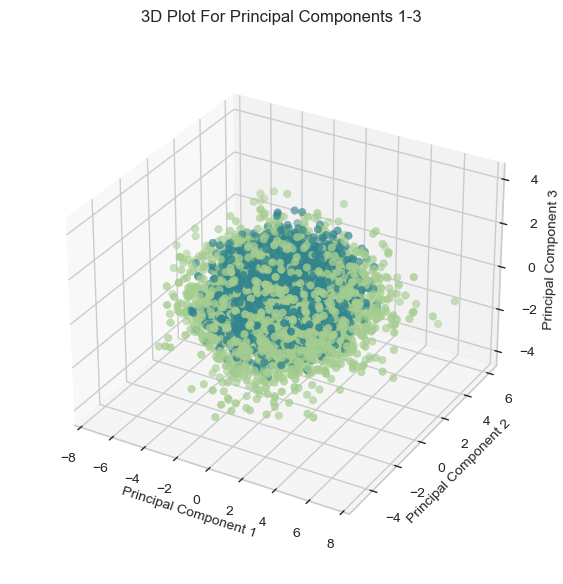

In [67]:
# Setting 3D Figure
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Specifying x and y axes
x = np.array(results_dbscan['PC1'])
y = np.array(results_dbscan['PC2'])
z = np.array(results_dbscan['PC3'])

# Setting axes labels
ax.set_xlabel('Principal Component 1', fontsize=10, rotation=150)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10, rotation=90)

# Plotting scatterplot
ax.scatter(x,y,z, c = results_dbscan["Segment_DBSCAN"], s=30, cmap = "crest")

# Setting title
plt.title('3D Plot For Principal Components 1-3')

# Scaling plot
ax.set_box_aspect(None, zoom=0.9)
plt.tight_layout()

The graph below shows the clustering without datapoints indicated as noise.

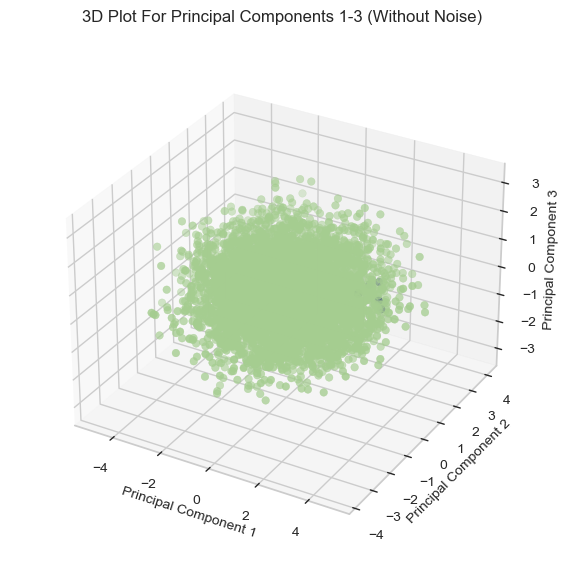

In [68]:
# Setting 3D Figure
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Specifying x and y axes
x = np.array(no_noise['PC1'])
y = np.array(no_noise['PC2'])
z = np.array(no_noise['PC3'])

# Setting axes labels
ax.set_xlabel('Principal Component 1', fontsize=10, rotation=150)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10, rotation=90)

# Plotting scatterplot
ax.scatter(x,y,z, c = no_noise["Segment_DBSCAN"], s=30, cmap = "crest")

# Setting title
plt.title('3D Plot For Principal Components 1-3 (Without Noise)')

# Scaling plot
ax.set_box_aspect(None, zoom=0.9)
plt.tight_layout()

The 3D plot above does not show much more information as the previous. It only eliminated the "outliers" or noise as indicated by the DBSCAN.

---
<h1><center>Comparing Results</center></h1>

**Comparing scatterplots for PC1 vs PC2 across all methods.** 

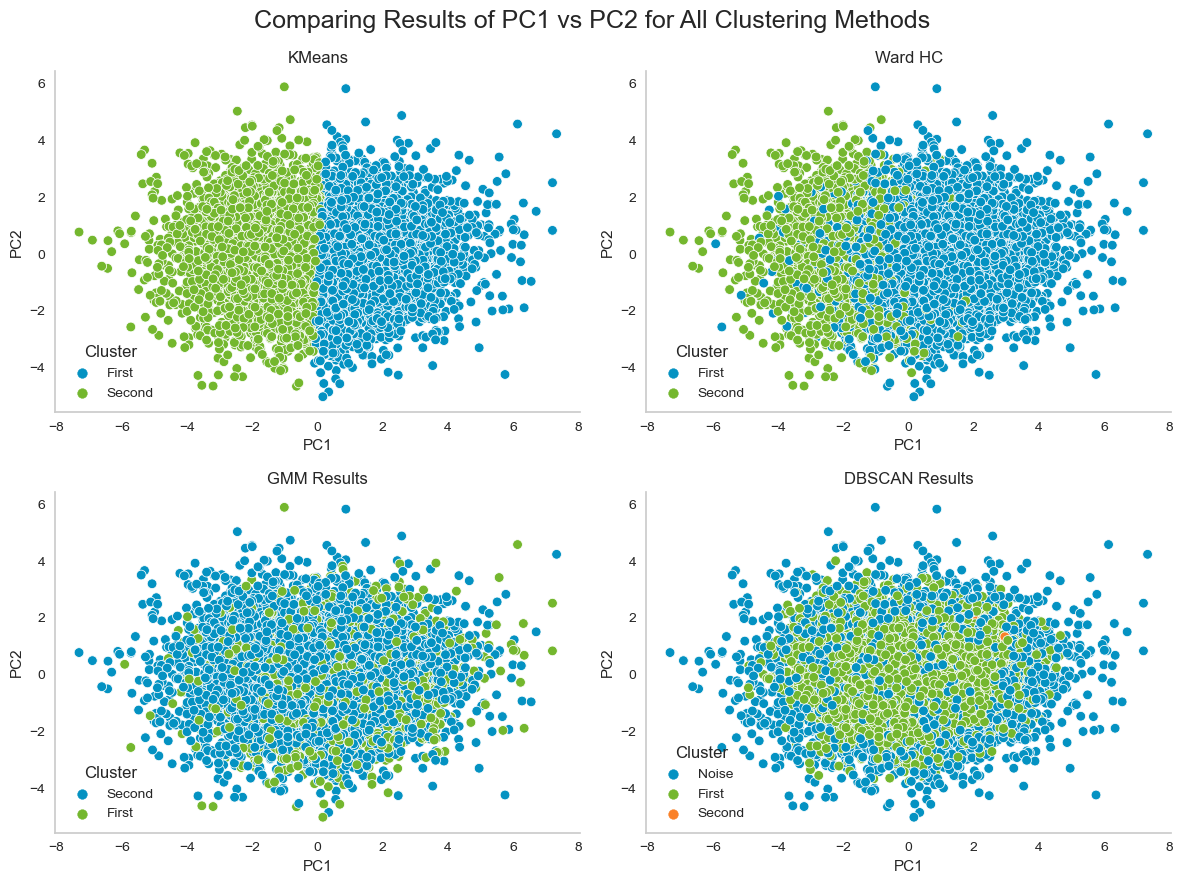

In [69]:
# Initializing 4 subplots in 2x2 matrix
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

# Plotting scatterplots of PC1 and PC2 for each model
# KMeans
sns.scatterplot(data = results_kmeans, x = "PC1", y = 'PC2', hue = 'Cluster', palette = palette_2_clusters, 
                hue_order = ['First', 'Second'], ax = ax[0, 0])

# Hierarchical Clustering
sns.scatterplot(data = results_hc, x = "PC1", y = 'PC2', hue = 'Cluster', palette = palette_2_clusters, 
                hue_order = ['First', 'Second'], ax = ax[0, 1])

# GMM
sns.scatterplot(data = results_gmm, x = "PC1", y = 'PC2', hue = 'Cluster', palette = palette_2_clusters, 
                ax = ax[1,0])

# DBSCAN
sns.scatterplot(data = results_dbscan, x = 'PC1', y = 'PC2', hue = 'Cluster', palette = palette_3_clusters, 
                ax = ax[1, 1])

# Setting legend location
ax[0, 0].legend(loc ='lower left', title = 'Cluster')
ax[0, 1].legend(loc ='lower left', title = 'Cluster')
ax[1, 0].legend(loc ='lower left', title = 'Cluster')
ax[1, 1].legend(loc ='lower left', title = 'Cluster')

# Setting titles
plt.suptitle('Comparing Results of PC1 vs PC2 for All Clustering Methods', fontsize = 18)
ax[0, 0].set_title('KMeans')
ax[0, 1].set_title('Ward HC')
ax[1, 0].set_title('GMM Results')
ax[1, 1].set_title('DBSCAN Results')

# Turning off grid
ax[0, 0].grid(False)
ax[0, 1].grid(False)
ax[1, 0].grid(False)
ax[1, 1].grid(False)

# Setting style of plots
sns.despine()
plt.tight_layout()

# plt.savefig('clustering_results4.png', dpi = 1000, bbox_inches='tight')

Looking at the four clustering methods side-by-side, we can see that KMeans performed the best with respect to identifying clusters and drawing clear lines between them. DBSCAN and GMM performed the worst and Ward HC was in the middle.

In [70]:
# Getting the silhouette scores for each model
kmeans_score = silhouette_score(X, kmeans_pca.labels_)
hc_score = silhouette_score(X, hc_ward.labels_)
gmm_score = silhouette_score(X, gmm.predict(X))
dbscan_score = silhouette_score(X, best_dbscan.labels_)

# Printing the scores
print('Silhouette Score for Best K-Means: %.3f' % kmeans_score)
print('Silhouette Score for Best Hierarchical Clustering: %.3f' % hc_score)
print('Silhouette Score for Best Gaussian Mixture Model: %.3f' % gmm_score)
print('Silhouette Score for Best DBSCAN: %.3f' % dbscan_score)

Silhouette Score for Best K-Means: 0.158
Silhouette Score for Best Hierarchical Clustering: 0.112
Silhouette Score for Best Gaussian Mixture Model: 0.118
Silhouette Score for Best DBSCAN: 0.034


The silhouette score is clearly the highest for K-Means and lowest for DBSCAN. HC and GMM are both very similar, but the graphs might indicate that HC is better despite GMM's slightly higher silhouette score.

**Boxplots for All Features in All Clustering Methods**

**K-Means:**

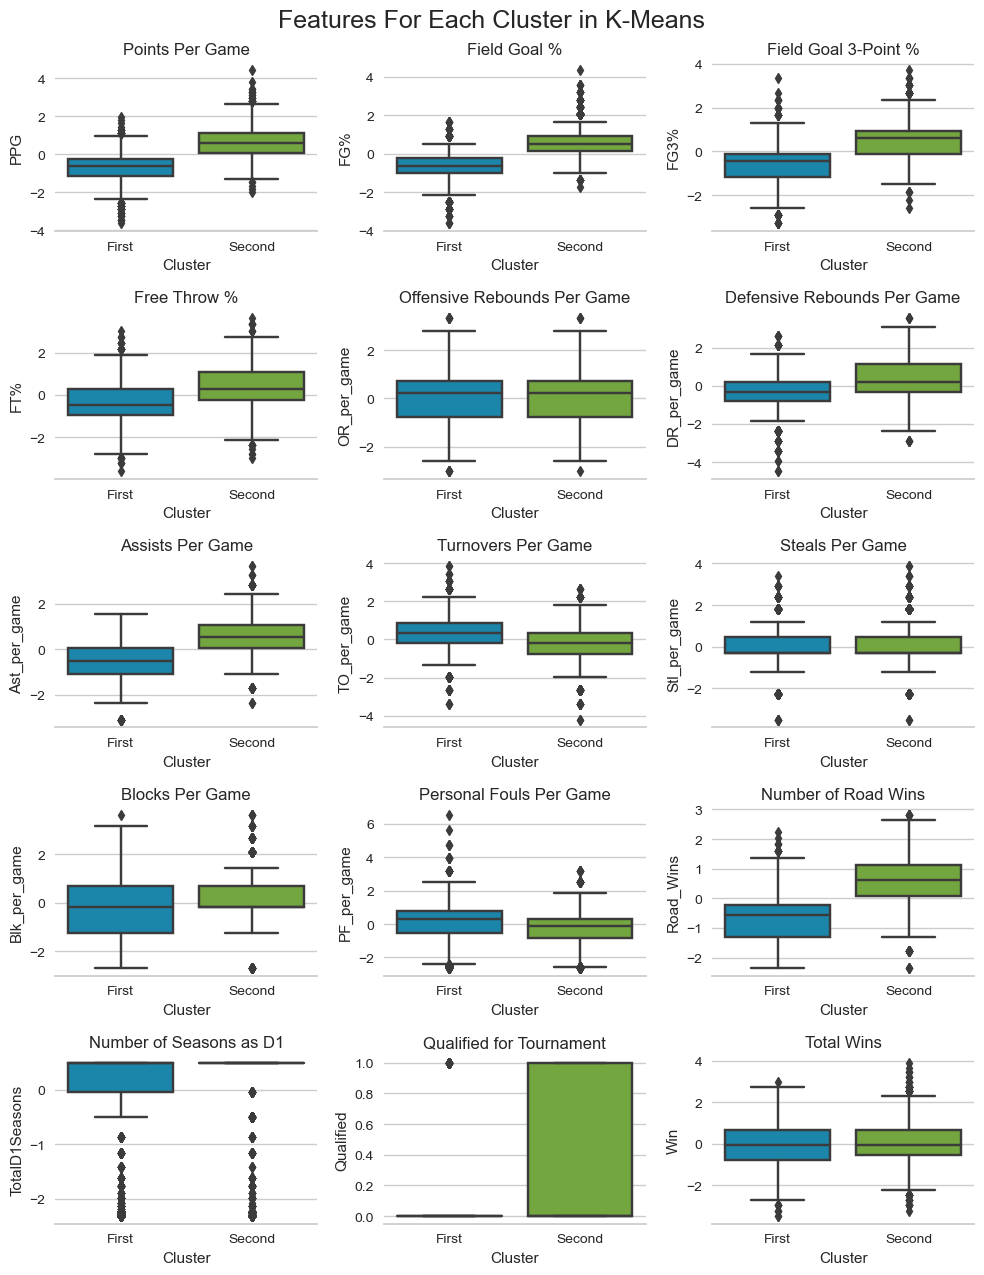

In [71]:
# Initializing subplots
fig, ax = plt.subplots(5, 3, figsize=(10, 13))

# Setting axis indexes
j = 0
h = 0

# Creating for loop to plot each feature
for i in features:
    sns.boxplot(data = results_kmeans, x = "Cluster", y = i, ax = ax[h, j], palette = palette_2_clusters, 
                order = ['First', 'Second'])
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Setting axis indexes
j=0
h=0

# Iterating through title names to give each plot
for i in titles:
    ax[h, j].set_title(i)
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Main title
plt.suptitle('Features For Each Cluster in K-Means', fontsize = 18)
sns.set_style('whitegrid')       
sns.despine(left = True)
plt.tight_layout()

The K-Means shows that the Second Cluster is performing better than the first in terms of almost all features except turnovers per game and personal fouls per game, where the IQR for the First Cluster is higher. The Second Cluster accounts for all teams who are qualified for the tournament. Interestingly, total wins does not appear to be a key differentiator between the two clusters.

**HC Ward:**

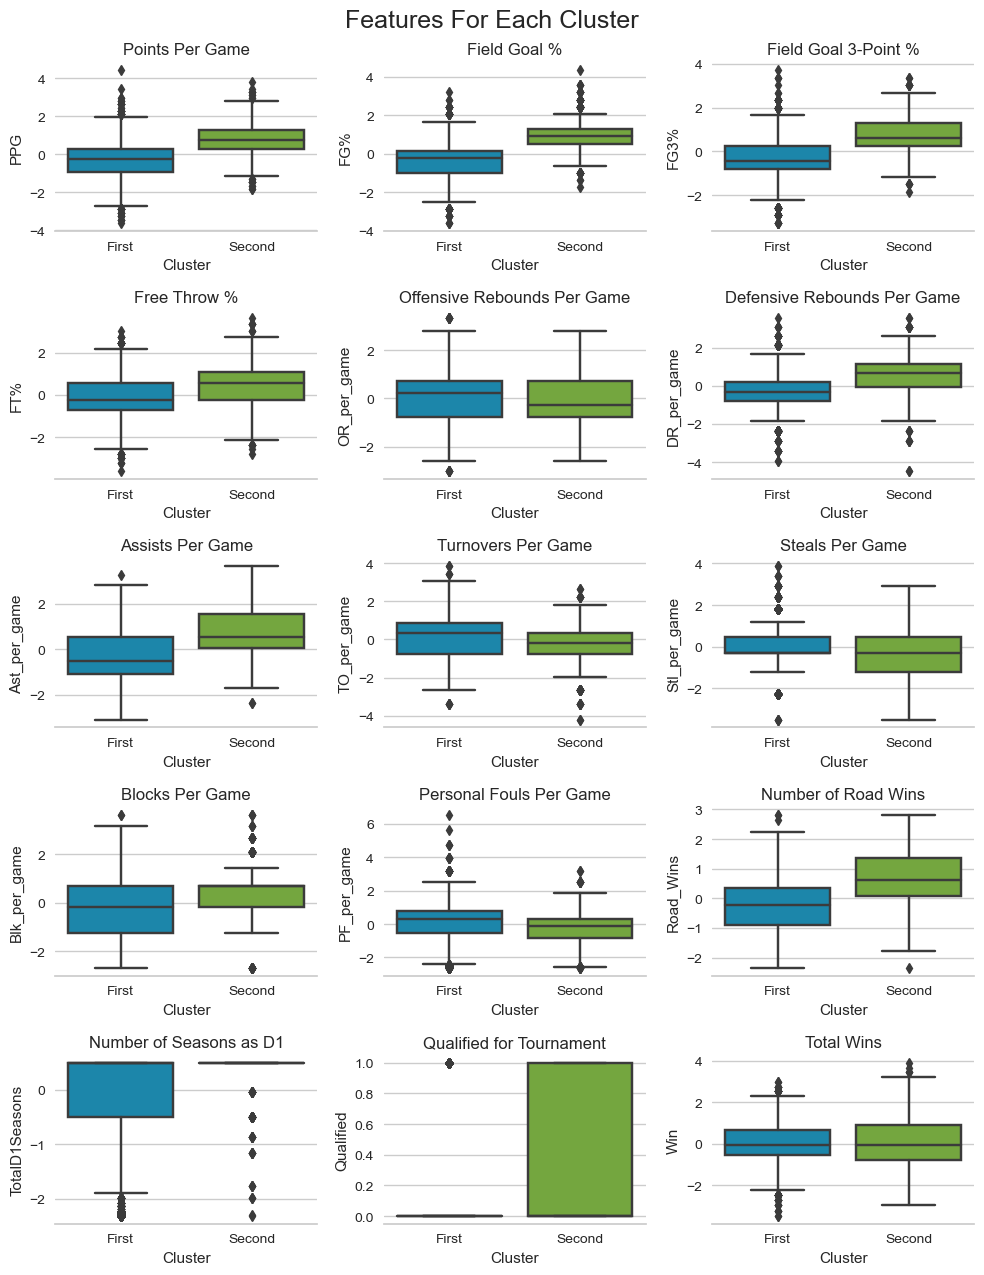

In [72]:
# Initializing subplots
fig, ax = plt.subplots(5, 3, figsize=(10, 13))

# Setting axis indexes
j = 0
h = 0

# Creating for loop to plot each feature
for i in features:
    sns.boxplot(data = results_hc, x = "Cluster", y = i, ax = ax[h, j], palette = palette_2_clusters, 
                order = ['First', 'Second'])
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Setting axis indexes
j=0
h=0

# Iterating through title names to give each plot
for i in titles:
    ax[h, j].set_title(i)
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Main title
plt.suptitle('Features For Each Cluster', fontsize = 18)
sns.set_style('whitegrid')       
sns.despine(left = True)
plt.tight_layout()

The results of the clustering appear to be similar to K-Means, where the Second Cluster has better/higher performance metrics than the First Cluster. However, the IQRs overlap more and there is less clear differentiation.

**GMM:**

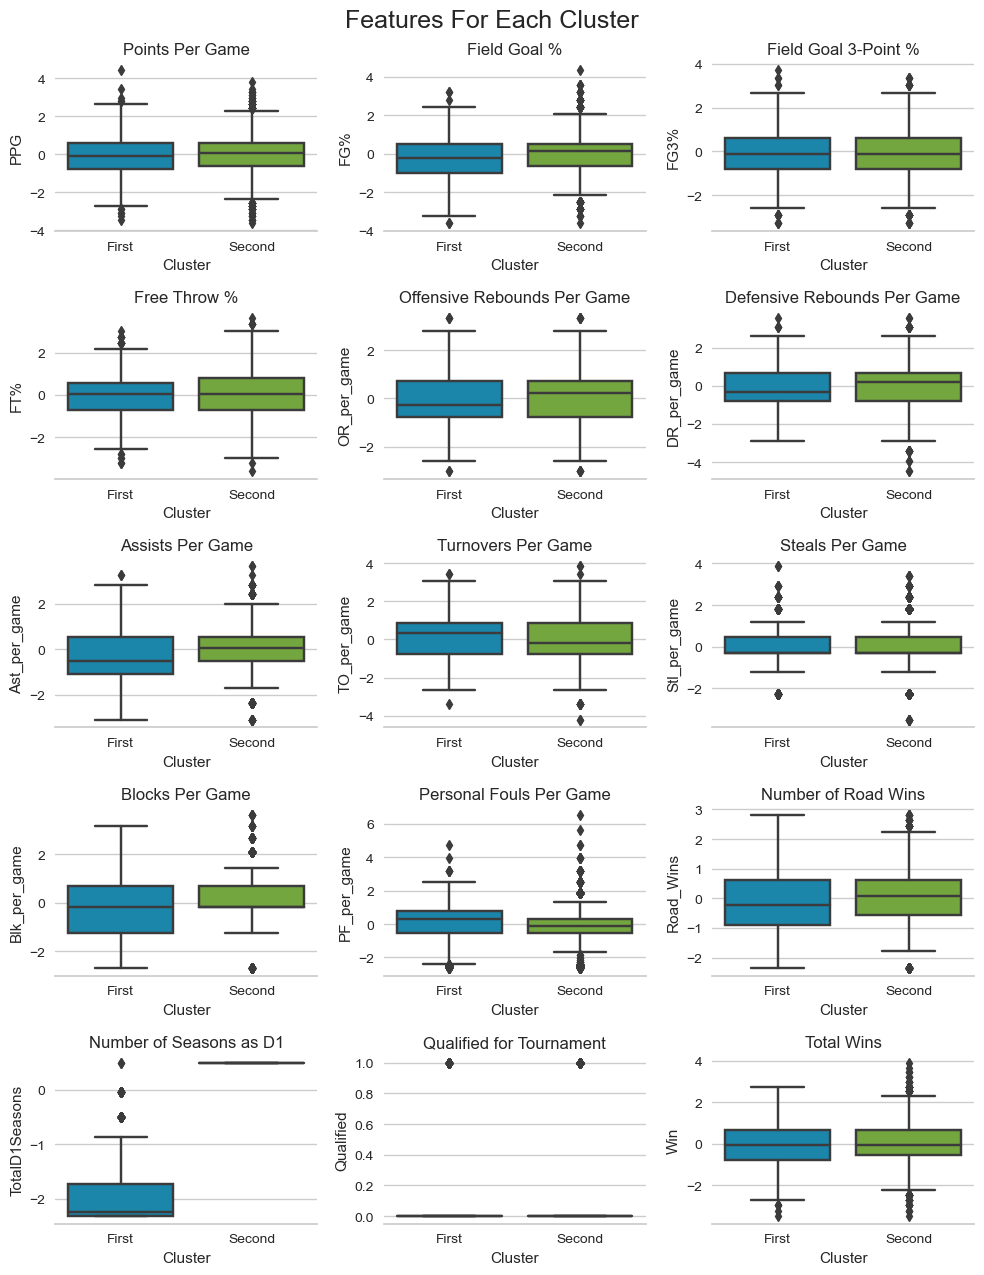

In [73]:
# Initializing subplots
fig, ax = plt.subplots(5, 3, figsize=(10, 13))

# Setting axis indexes
j = 0
h = 0

# Creating for loop to plot each feature
for i in features:
    sns.boxplot(data = results_gmm, x = "Cluster", y = i, ax = ax[h, j], palette = palette_2_clusters, 
                order = ['First', 'Second'])
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Setting axis indexes
j=0
h=0

# Iterating through title names to give each plot
for i in titles:
    ax[h, j].set_title(i)
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Main title
plt.suptitle('Features For Each Cluster', fontsize = 18)
sns.set_style('whitegrid')       
sns.despine(left = True)
plt.tight_layout()

The GMM does not show any clear differentiation between the First Cluster and the Second Cluster. In some cases, the IQR is larger for the First Cluster, suggesting higher variation. Unfortunately, the GMM does not provide us with any clear takeaways about these clusters.

**DBSCAN:**

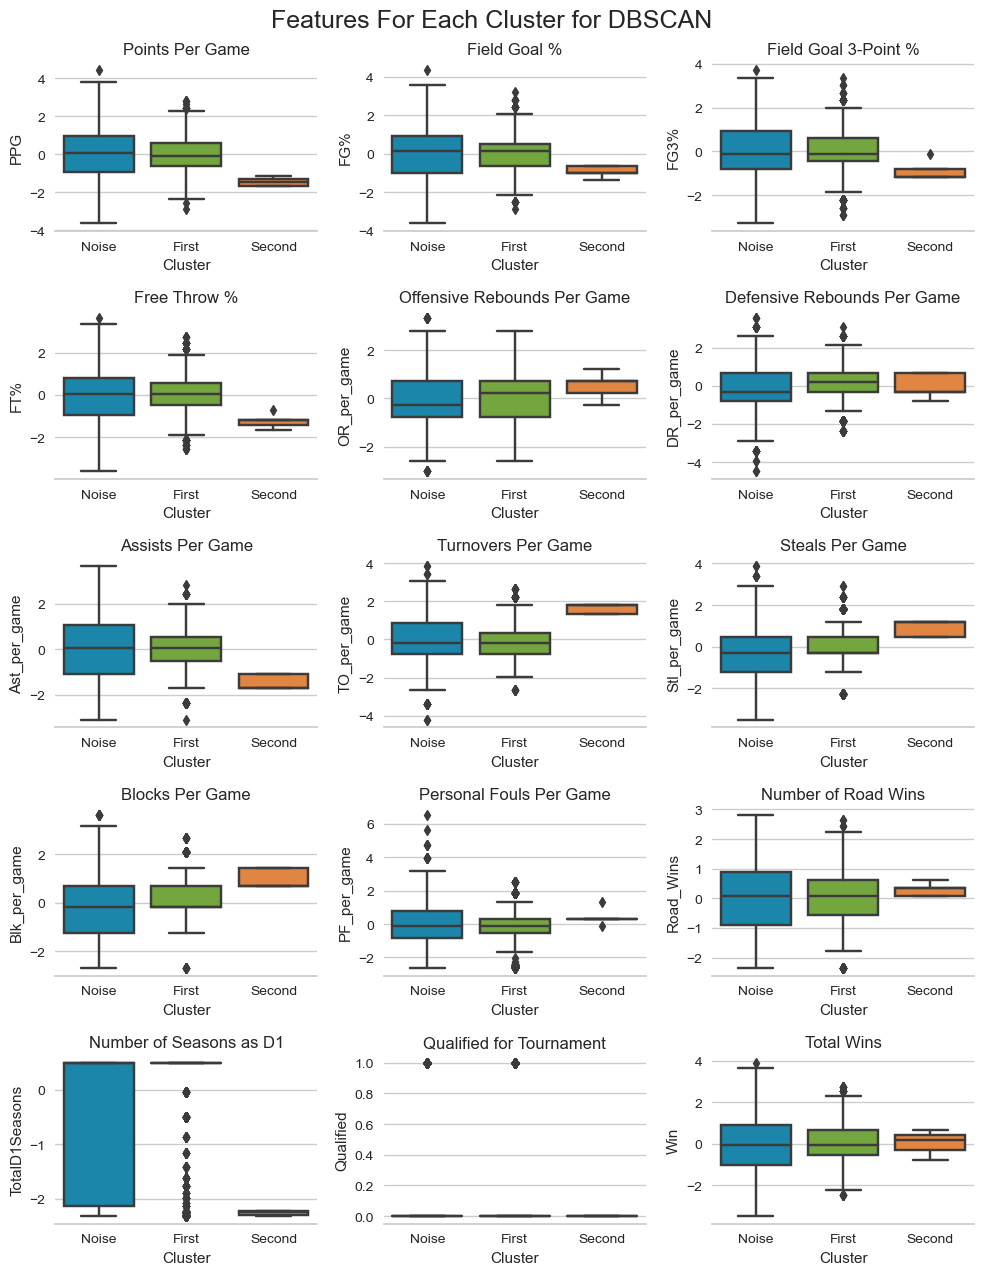

In [74]:
# Initializing subplots
fig, ax = plt.subplots(5, 3, figsize=(10, 13))

# Setting axis indexes
j = 0
h = 0

# Creating for loop to plot each feature
for i in features:
    sns.boxplot(data = results_dbscan, x = "Cluster", y = i, ax = ax[h, j], palette = palette_3_clusters, 
                order = ['Noise', 'First', 'Second'])
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Setting axis indexes
j=0
h=0

# Iterating through title names to give each plot
for i in titles:
    ax[h, j].set_title(i)
    if j < 2:
        j = j + 1
    else:
        j = 0
        h = h + 1
         
# Main title
plt.suptitle('Features For Each Cluster for DBSCAN', fontsize = 18)

# Setting style aspects
sns.set_style('whitegrid')       
sns.despine(left = True)
plt.tight_layout()

Similar to the GMM, the DBSCAN does not provide us with clear insights about the two clusters (and the noise). Because there are so few datapoints in the second cluster, it is hard to pull any meaningful insight about it. However, the IQRs are larger for the noise group, suggesting higher variation, while there is less variation for the First and Second cluster.

## What do the results of our best model tell us?

Below we read in the dataset about Team Names so we can pull insights from it.

In [75]:
# Reading in team dataset to get team names
team_info = pd.read_csv('data/MTeams.csv')

# Combining KMeans results with original df on TeamID and Season
winner = pd.concat([results_kmeans, team_data[['Team', 'Season']]], axis = 1)

# Dropping null values
winner.dropna(inplace = True)

# Merging the team names df to the KMeans results df
final = winner.merge(team_info, left_on = 'Team', right_on = 'TeamID', how = 'left')

# Creating df for just 2023 teams
final_2023 = final[final['Season'] == 2023]

Below are histogram plots looking a some features that differentiate the two clusters.

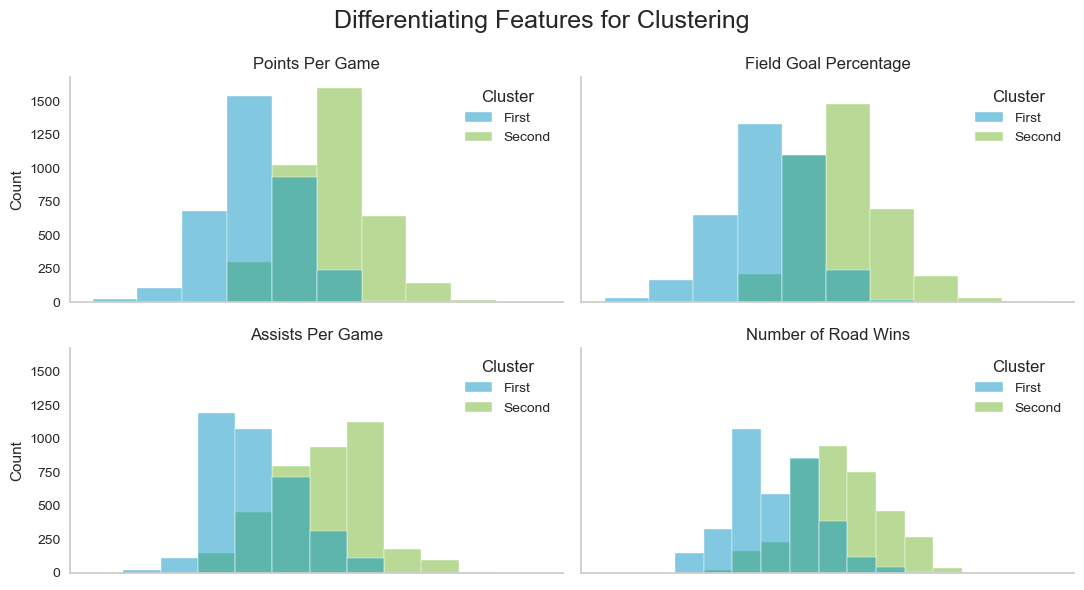

In [76]:
# Initializing 4 subplots in 2x2 matrix
fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex = True, sharey = True)

# Plotting histograms to compare clusters for certain features
sns.histplot(data = final, x = 'PPG', hue = 'Cluster', bins = 10, ax = ax[0,0], palette = palette_2_clusters)
sns.histplot(data = final, x = 'FG%', hue = 'Cluster', bins = 10, ax = ax[0,1], palette = palette_2_clusters)
sns.histplot(data = final, x = 'Ast_per_game', hue = 'Cluster', bins = 10, ax = ax[1,0], palette = palette_2_clusters)
sns.histplot(data = final, x = 'Road_Wins', hue = 'Cluster', bins = 10, ax = ax[1,1], palette = palette_2_clusters)

# Setting titles
#plt.suptitle('Comparing Results of PC1 vs PC2 for All Clustering Methods', fontsize = 18)
ax[0, 0].set_title('Points Per Game')
ax[0, 1].set_title('Field Goal Percentage')
ax[1, 0].set_title('Assists Per Game')
ax[1, 1].set_title('Number of Road Wins')

# Turning off grid
ax[0, 0].grid(False)
ax[0, 1].grid(False)
ax[1, 0].grid(False)
ax[1, 1].grid(False)

# Turning of x ticks and labels
ax[1,0].set_xlabel('')
ax[1,0].set_xticks([])
ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])

# Main title
plt.suptitle('Differentiating Features for Clustering', fontsize = 18)

# Style changes
sns.despine()
plt.tight_layout()

These histograms show that the Second Cluster is performing better than the first with respect to Points Per Game, Field Goal Percentage, Assists Per Game, and Number of Road Wins. Clearly, we can see some differences between the two clusters.

Now let's look at features that were not key differentiators.

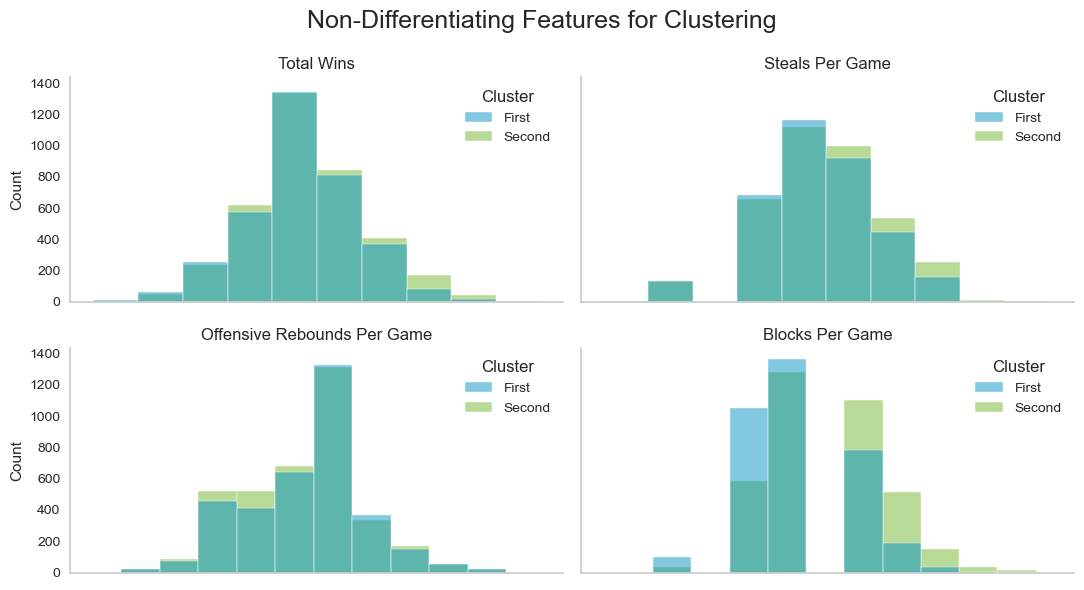

In [77]:
# Initializing 4 subplots in 2x2 matrix
fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex = True, sharey = True)

# Plotting histograms to compare clusters for certain features
sns.histplot(data = final, x = 'Win', hue = 'Cluster', bins = 10, ax = ax[0,0], palette = palette_2_clusters)
sns.histplot(data = final, x = 'Stl_per_game', hue = 'Cluster', bins = 10, ax = ax[0,1], palette = palette_2_clusters)
sns.histplot(data = final, x = 'OR_per_game', hue = 'Cluster', bins = 10, ax = ax[1,0], palette = palette_2_clusters)
sns.histplot(data = final, x = 'Blk_per_game', hue = 'Cluster', bins = 10, ax = ax[1,1], palette = palette_2_clusters)

# Setting titles
#plt.suptitle('Comparing Results of PC1 vs PC2 for All Clustering Methods', fontsize = 18)
ax[0, 0].set_title('Total Wins')
ax[0, 1].set_title('Steals Per Game')
ax[1, 0].set_title('Offensive Rebounds Per Game')
ax[1, 1].set_title('Blocks Per Game')

# Turning off grid
ax[0, 0].grid(False)
ax[0, 1].grid(False)
ax[1, 0].grid(False)
ax[1, 1].grid(False)

# Turning of x ticks and labels
ax[1,0].set_xlabel('')
ax[1,0].set_xticks([])
ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])

# Main title
plt.suptitle('Non-Differentiating Features for Clustering', fontsize = 18)

# Style changes
sns.despine()
plt.tight_layout()

As shown by the histograms above, the distributions for both the First and Second Cluster overlap (with the exception of Blocks Per Game being slightly higher for the Second Cluster). These features, unlike the previous four, are not key differentiators between the two clusters.

Since we know that the Second Cluster is performing better, let's look to see if there are trends in Conferences such that better teams (Second Cluster) are in certain conferences and vice versa.

Text(0.5, 1.0, '2023 Conferences Broken Down By Cluster')

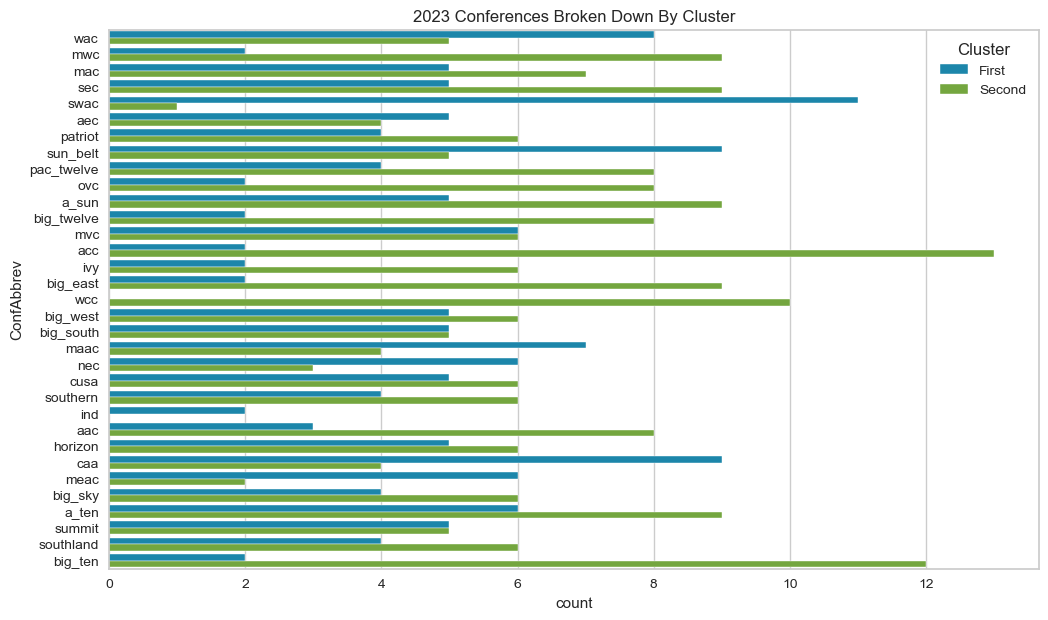

In [78]:
# Reading in conference dataset
team_conf = pd.read_csv('data/MTeamConferences.csv')
team_conf = team_conf[team_conf['Season'] == 2023]

# Creating a df with conference names
conf_final = final_2023.merge(team_conf, right_on = ['Season', 'TeamID'], left_on = ['Season', 'TeamID'], how = 'left')

# Setting the figure size
plt.figure(figsize=(12,7))

# Plotting bar plot to see which conferences are common for each cluster
sns.countplot(data = conf_final, y = "ConfAbbrev", hue = "Cluster", palette = palette_2_clusters)

# Setting title
plt.title('2023 Conferences Broken Down By Cluster')

The Second Cluster has a large amount of teams from the ACC conference and the Big Ten conference, which makes sense given that a the ACC and Big Ten are conferences known to have strong teams.

---
## Conclusion

The KMeans clustering method performed best with respect to clustering the data on Teams across all seasons. The KMeans found 2 clusters: cluster 1 with lower-performing teams and cluster 2 with higher-performing teams. The clustering also showed us that the higher-performing teams also performed better on certain metrics, such as number of road wins, points per game, and defensive rebounds per game. The project also showed that KMeans and Hierarchical Clustering performed best whereas GMM and DBSCAN were less successful.


**Limitations and Future Work**

* If this clustering project were to be improved upon, one route worth considering is looking into different dimensionality reduction methods, such as MDS or isometric mapping from manifold learning. 
* An additional improve would include adding more features outside of game statistics, such as college-level atheltic funding.
* The data used was for 2003-2023. Another interesting project would look at each season to see if the clustering methods change over time.

---
**References**

* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* https://365datascience.com/tutorials/python-tutorials/pca-k-means/
* https://openclassrooms.com/en/courses/5869986-perform-an-exploratory-data-analysis/6177861-analyze-the-results-of-a-k-means-clustering
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
* https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
* https://www.kaggle.com/code/vipulgandhi/gaussian-mixture-models-clustering-explained
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
* https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
* https://www.statology.org/seaborn-boxplot-order-x-axis/
* https://seaborn.pydata.org/tutorial/aesthetics.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
* https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
* https://github.com/IDB-FOR-DATASCIENCE/Unsupervised-ML-Modelling-for-Segmentation/blob/main/Segmentation%20Notebook%20_Final.ipynb
* https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
* https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29
* https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan
* https://stackoverflow.com/questions/43476053/visualizing-3d-clustering-using-matplotlib